In [1]:
# !pip install tensorflow_probability
# !pip install --upgrade tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('Data.csv')

In [4]:
data.head()

m49_code  country region  cpc_code     commodity  year  loss_percentage  \
0       104  Myanmar    NaN  23161.02  Rice, milled  2015             1.78   
1       104  Myanmar    NaN  23161.02  Rice, milled  2015            11.77   
2       104  Myanmar    NaN  23161.02  Rice, milled  2015             5.88   
3       104  Myanmar    NaN  23161.02  Rice, milled  2015             3.57   
4       104  Myanmar    NaN  23161.02  Rice, milled  2015            17.65   

  loss_percentage_original loss_quantity activity food_supply_stage  \
0                    1.78%      26.12kgs  Storage           Storage   
1                   11.77%      88.18kgs  Storage           Storage   
2                    5.88%      44.09kgs  Storage           Storage   
3                    3.57%      52.24kgs  Storage           Storage   
4                   17.65%     132.27kgs  Storage           Storage   

                        treatment cause_of_loss sample_size  \
0  30 days storage, with trapping       Rodents         NaN   
1    60 days storage, no trapping       Rodents         NaN   
2    30 days storage, no trapping       Rodents         NaN   
3  60 days storage, with trapping       Rodents         NaN   
4    90 days storage, no trapping       Rodents         NaN   

  method_data_collection                                          reference  \
0  Controlled Experiment  Dr Steven Belmain (2015), context post-harvest...   
1  Controlled Experiment  Dr Steven Belmain (2015), context post-harvest...   
2  Controlled Experiment  Dr Steven Belmain (2015), context post-harvest...   
3  Controlled Experiment  Dr Steven Belmain (2015), context post-harvest...   
4  Controlled Experiment  Dr Steven Belmain (2015), context post-harvest...   

   url                                        notes  
0  NaN   Reference has been generated automatically  
1  NaN   Reference has been generated automatically  
2  NaN   Reference has been generated automatically  
3  NaN   Reference has been generated automatically  
4  NaN   Reference has been generated automatically

## Preprocessing

In [5]:
# Lowercasing all country names

for col in ['country', 'commodity', 'activity', 'food_supply_stage', 'cause_of_loss', 'method_data_collection', 'treatment']:
    data[col] = data[col].str.strip().str.lower()


# Sorting data by year in ascending order

data.sort_values(by = ['year'], ascending = True, inplace = True)


# Dropping irrelevant columns

data.drop(columns = ['m49_code', 'cpc_code', 'loss_percentage_original', 'reference', 'url',
                           'notes'], inplace = True)

In [6]:
# Splitting the dataframe into country level and continent level data

continent_level_data = data[data.country.isin(['asia', 'africa', 'north america', 'europe', 'south america', 'australia and new zealand'])].reset_index(drop = True)

country_level_data = data[~data.country.isin(['asia', 'africa', 'north america', 'europe', 'south america', 'australia and new zealand'])].reset_index(drop = True)

### Cases with data collection methods other than modelled estimates

In [7]:
non_modelled_estimates = country_level_data[country_level_data.method_data_collection != "modelled estimates"]

In [8]:
non_modelled_estimates.shape

(8408, 12)

In [9]:
# Wherever food supply stage is not present, appending activity to that

non_modelled_estimates.food_supply_stage = np.where(non_modelled_estimates.food_supply_stage.isnull(),
                                                   non_modelled_estimates.activity,
                                                   non_modelled_estimates.food_supply_stage)

In [10]:
# Grouping the data using the key - {country, commodity, year, food supply stage} and obtaining time series length for each group

grouped_nm_estimates = non_modelled_estimates.groupby(['country', 'commodity', 'year', 'food_supply_stage']).agg({'loss_percentage':np.mean,
                                                                                            'cause_of_loss':pd.Series.mode}).reset_index()

grouped_nm_estimates['main_key'] = grouped_nm_estimates['country'] + '_' + grouped_nm_estimates['commodity'] + '_' + grouped_nm_estimates['food_supply_stage']

num_unique_years_nm = grouped_nm_estimates.groupby(['country', 'commodity', 'food_supply_stage']).year.nunique().reset_index()
num_unique_years_nm['key'] = num_unique_years_nm['country'] + '_' + num_unique_years_nm['commodity'] + '_' + num_unique_years_nm['food_supply_stage']

In [11]:
# Total number of data points for significant keys (over 5 unique years)

num_unique_years_nm[num_unique_years_nm.year>=5].year.sum()

2551

In [12]:
grouped_nm_estimates.head()

country   commodity  year   food_supply_stage  loss_percentage  \
0    algeria    potatoes  1991  whole supply chain        10.000000   
1    algeria    potatoes  2005  whole supply chain        25.000000   
2  argentina    potatoes  1991  whole supply chain         8.000000   
3  argentina  soya beans  2019             storage         0.503077   
4    armenia      apples  2009                farm        47.000000   

  cause_of_loss                               main_key  
0            []    algeria_potatoes_whole supply chain  
1            []    algeria_potatoes_whole supply chain  
2            []  argentina_potatoes_whole supply chain  
3            []           argentina_soya beans_storage  
4            []                    armenia_apples_farm

In [13]:
# Only keeping those keys at least 5 data points (5 years of data)

num_unique_years_nm = num_unique_years_nm[num_unique_years_nm.year>=5]

final_data = grouped_nm_estimates[grouped_nm_estimates['main_key'].isin(num_unique_years_nm['key'].unique())].reset_index(drop = True).sort_values(by = 'year', ascending = True).reset_index(drop = True)

In [14]:
# Checking whether there is a minimum amount of variation in loss percentage values

num_unique_loss_percentages = final_data.groupby(['main_key']).loss_percentage.nunique().reset_index()
good_keys = list(num_unique_loss_percentages[num_unique_loss_percentages.loss_percentage>1].main_key.unique())

In [15]:
# Keeping only those keys where more than 2 unique values are present in the time series

final_reliable_data = final_data[final_data.main_key.isin(good_keys)].reset_index(drop = True)

In [16]:
final_reliable_data.shape

(598, 7)

In [17]:
final_reliable_data.main_key.nunique()

44

In [18]:
final_reliable_data.head()

country                 commodity  year  \
0                  pakistan                     wheat  1966   
1                     kenya              maize (corn)  1969   
2                     ghana              maize (corn)  1969   
3  united states of america  hen eggs in shell, fresh  1970   
4  united states of america       lettuce and chicory  1970   

    food_supply_stage  loss_percentage  \
0             storage            12.00   
1             storage            14.25   
2             storage            12.75   
3  whole supply chain             2.17   
4  whole supply chain             8.50   

                                 cause_of_loss  \
0  public sector storage losses due to rodents   
1                                           []   
2                                           []   
3                                           []   
4                                           []   

                                            main_key  
0                             pakistan_wheat_storage  
1                         kenya_maize (corn)_storage  
2                         ghana_maize (corn)_storage  
3  united states of america_hen eggs in shell, fr...  
4  united states of america_lettuce and chicory_w...

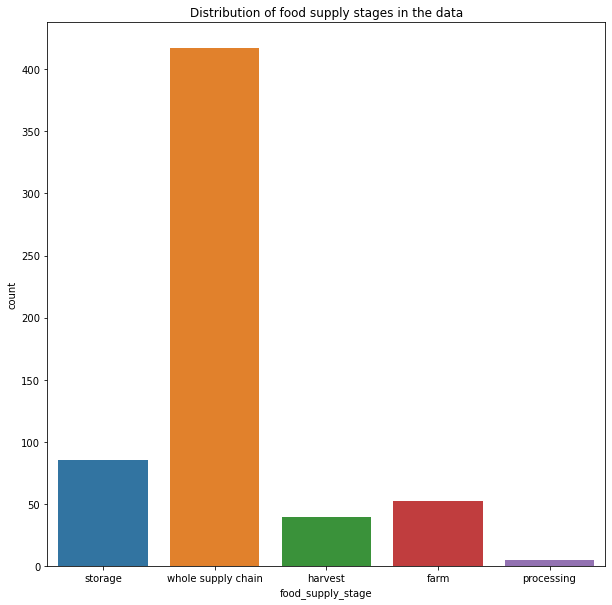

In [19]:
plt.figure(figsize = (10,10))
plt.title('Distribution of food supply stages in the data')
sns.countplot(x = final_reliable_data.food_supply_stage)
plt.show()

In [20]:
final_reliable_data.head()

country                 commodity  year  \
0                  pakistan                     wheat  1966   
1                     kenya              maize (corn)  1969   
2                     ghana              maize (corn)  1969   
3  united states of america  hen eggs in shell, fresh  1970   
4  united states of america       lettuce and chicory  1970   

    food_supply_stage  loss_percentage  \
0             storage            12.00   
1             storage            14.25   
2             storage            12.75   
3  whole supply chain             2.17   
4  whole supply chain             8.50   

                                 cause_of_loss  \
0  public sector storage losses due to rodents   
1                                           []   
2                                           []   
3                                           []   
4                                           []   

                                            main_key  
0                             pakistan_wheat_storage  
1                         kenya_maize (corn)_storage  
2                         ghana_maize (corn)_storage  
3  united states of america_hen eggs in shell, fr...  
4  united states of america_lettuce and chicory_w...

## Wordclouds

In [42]:
# final_reliable_data.cause_of_loss = final_reliable_data.cause_of_loss.map(lambda x: str(x))

In [43]:
# commodity_text = ' '.join(final_reliable_data[final_reliable_data.commodity == 'wheat']['cause_of_loss'].astype(str))

In [44]:
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(commodity_text)
# plt.figure(figsize=(10, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Major causes of loss for wheat')
# plt.show()

# Modelling

#### Plotting all keys

In [21]:
final_reliable_data.shape

(598, 7)

In [22]:
final_reliable_data.head()

country                 commodity  year  \
0                  pakistan                     wheat  1966   
1                     kenya              maize (corn)  1969   
2                     ghana              maize (corn)  1969   
3  united states of america  hen eggs in shell, fresh  1970   
4  united states of america       lettuce and chicory  1970   

    food_supply_stage  loss_percentage  \
0             storage            12.00   
1             storage            14.25   
2             storage            12.75   
3  whole supply chain             2.17   
4  whole supply chain             8.50   

                                 cause_of_loss  \
0  public sector storage losses due to rodents   
1                                           []   
2                                           []   
3                                           []   
4                                           []   

                                            main_key  
0                             pakistan_wheat_storage  
1                         kenya_maize (corn)_storage  
2                         ghana_maize (corn)_storage  
3  united states of america_hen eggs in shell, fr...  
4  united states of america_lettuce and chicory_w...

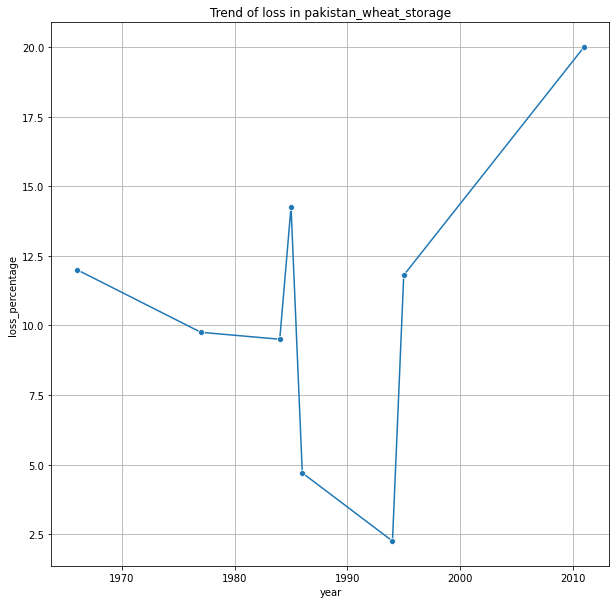

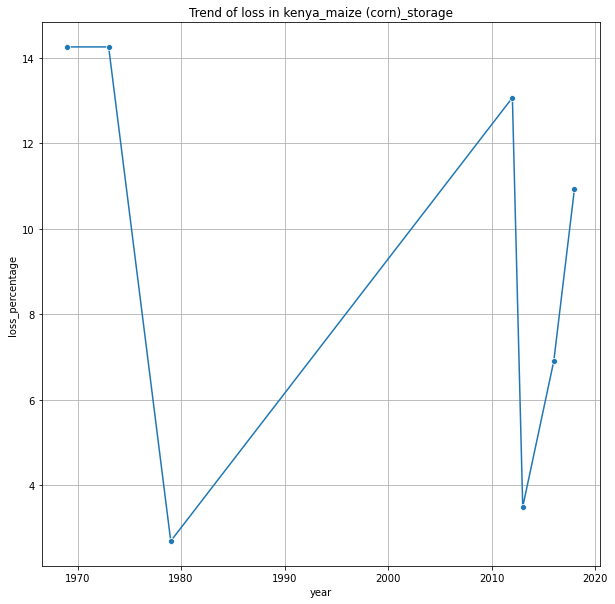

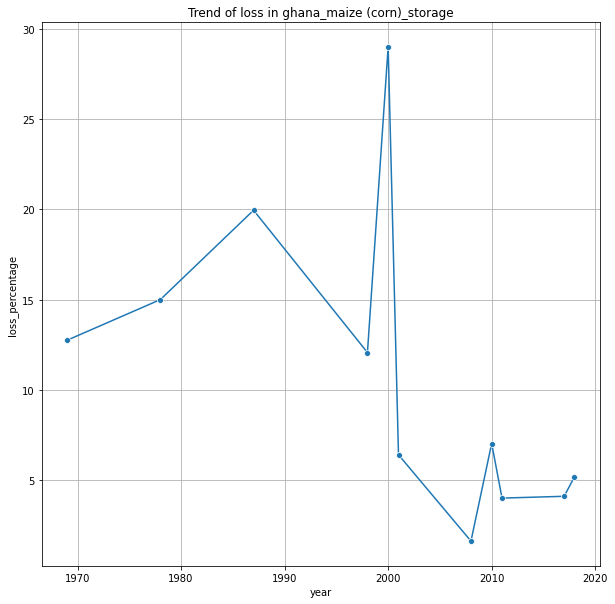

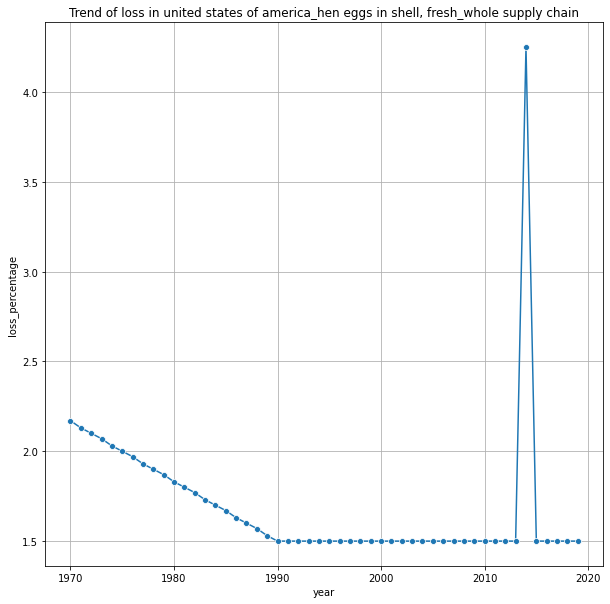

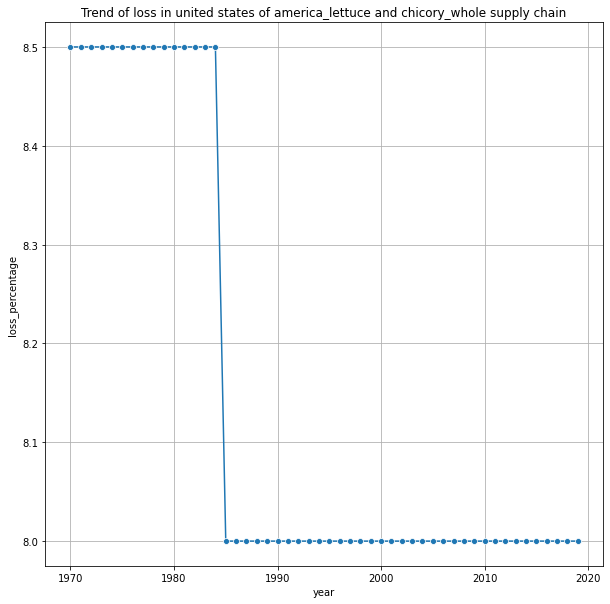

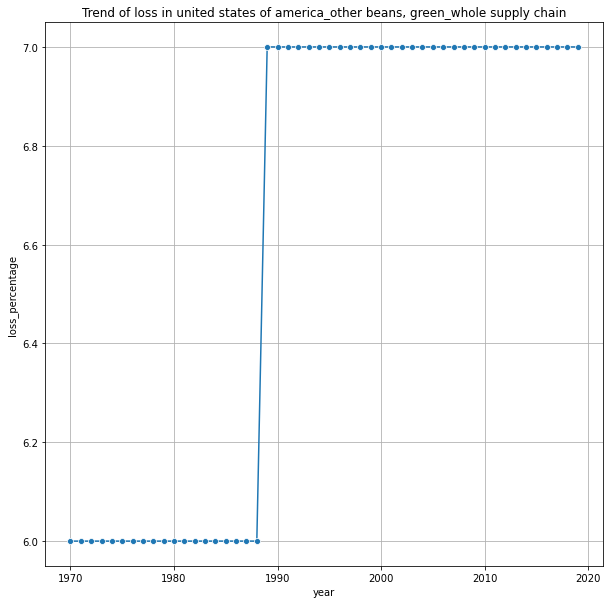

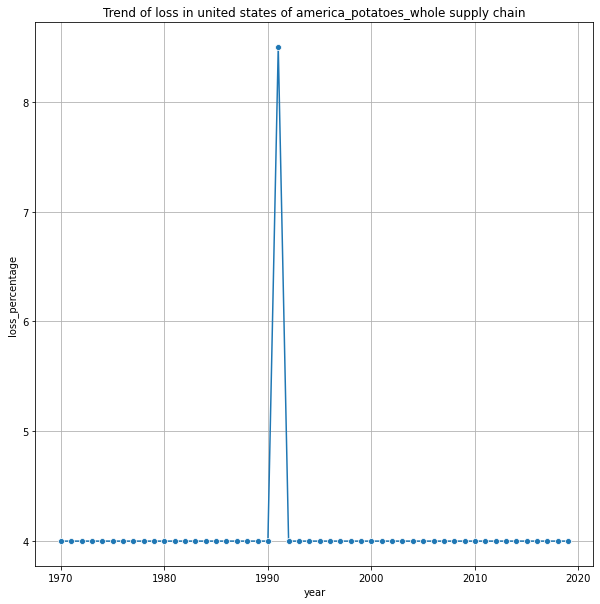

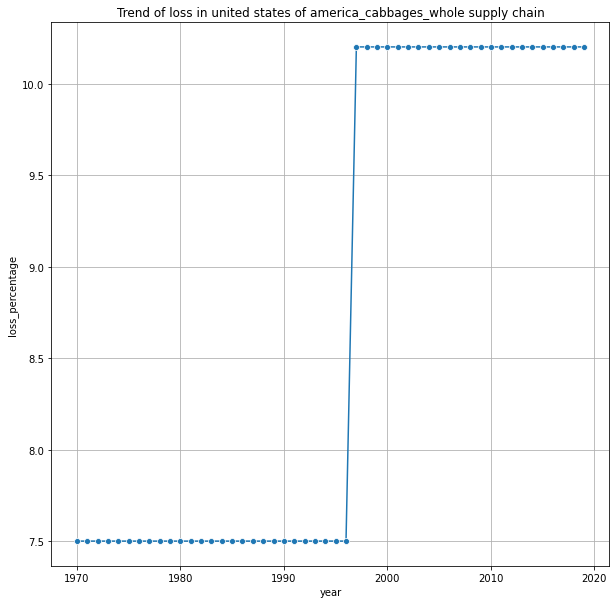

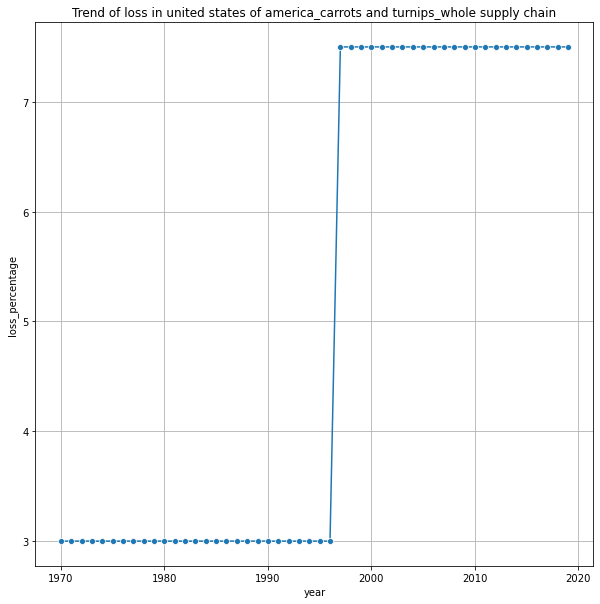

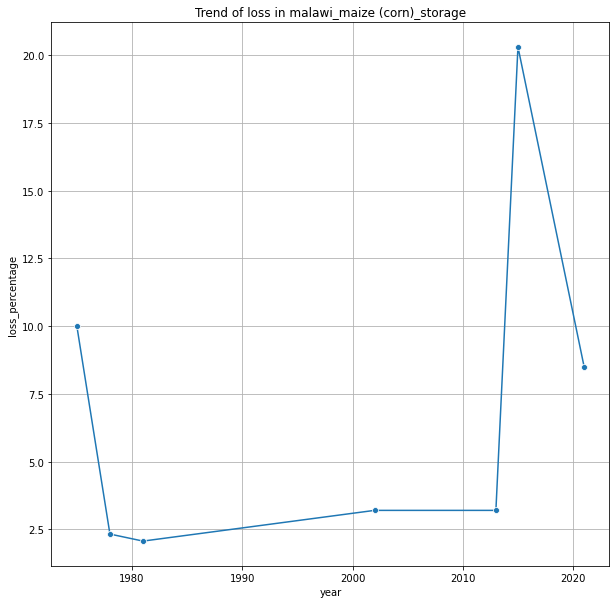

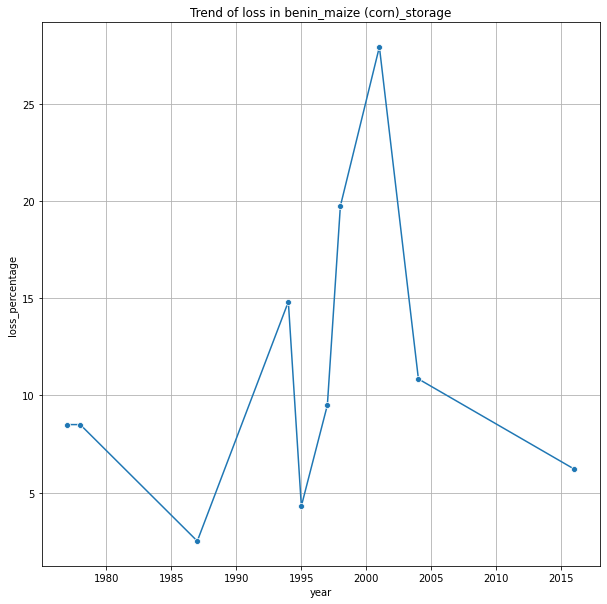

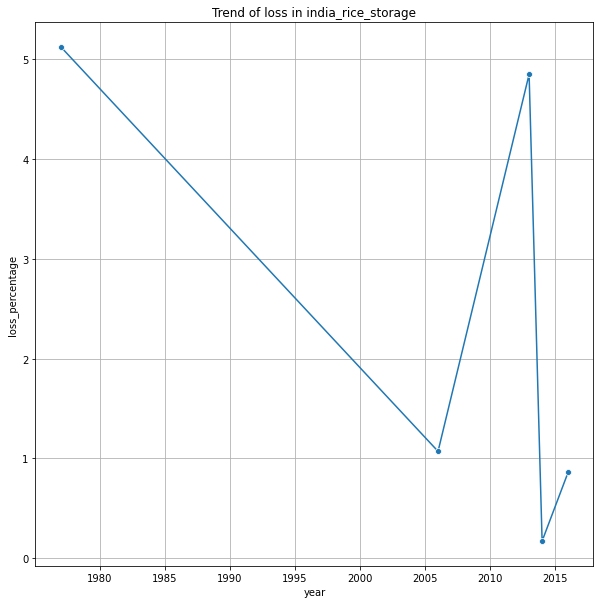

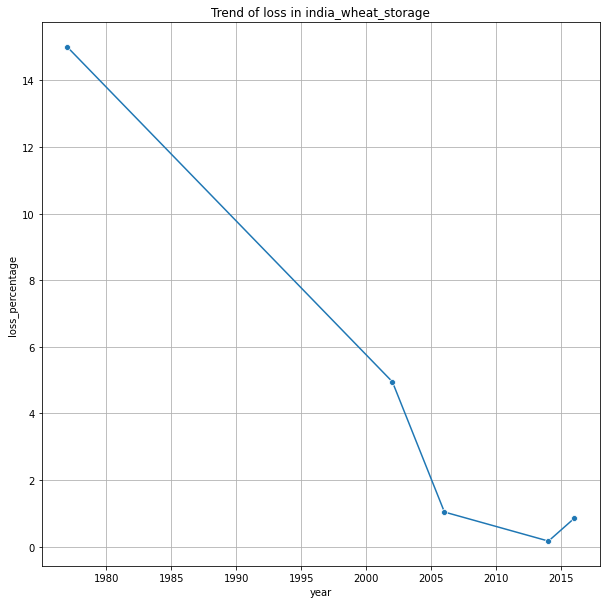

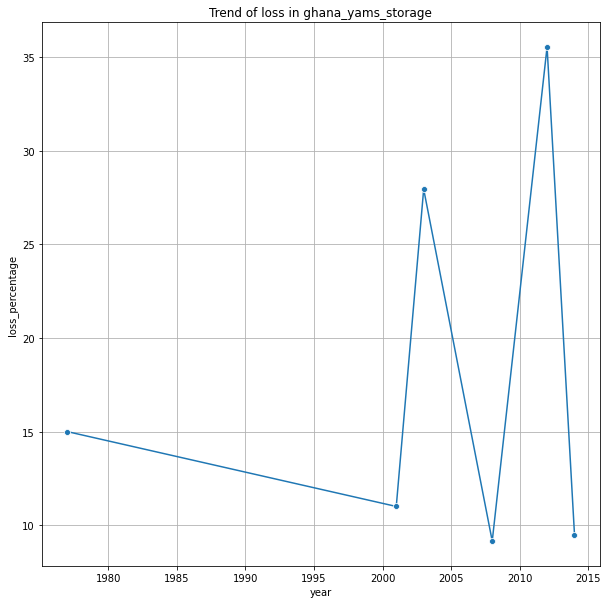

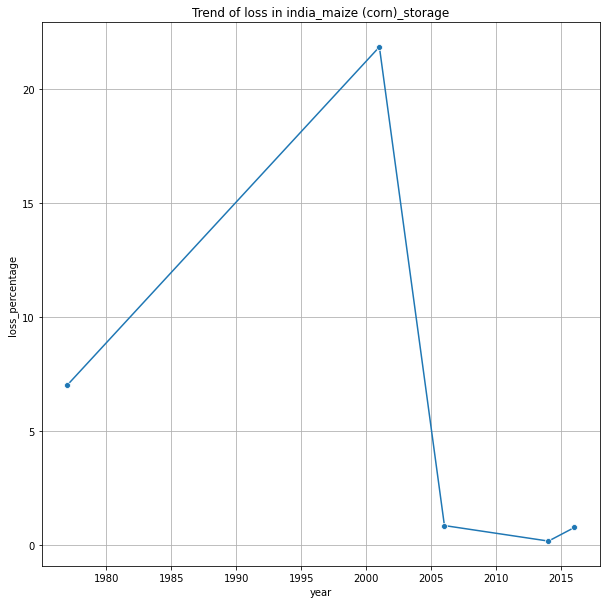

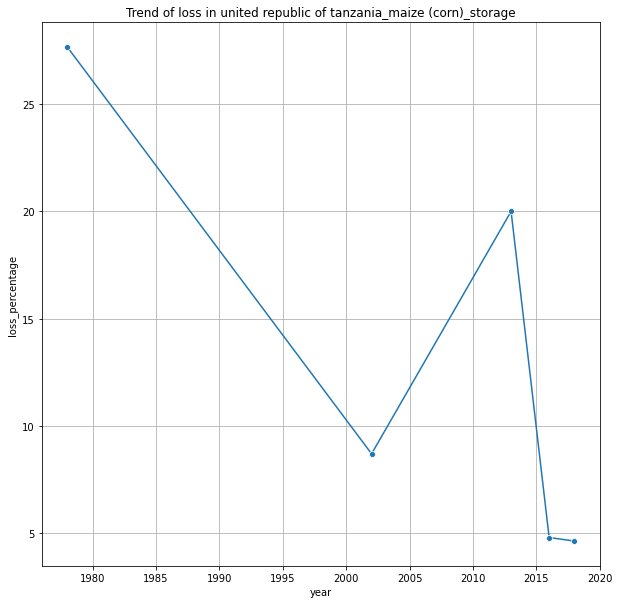

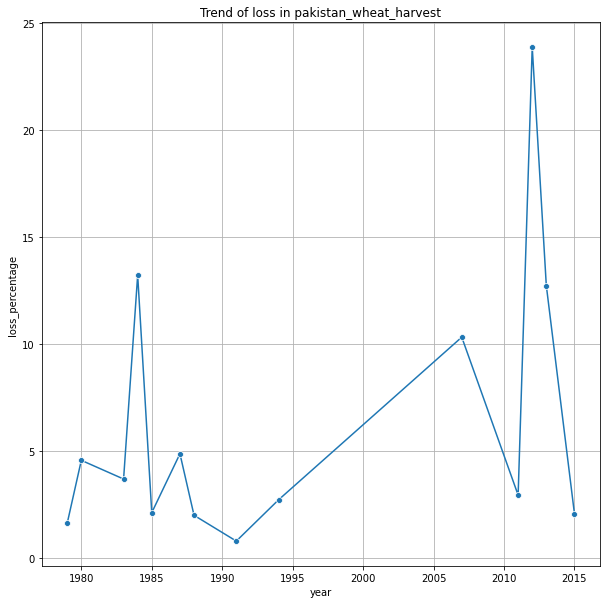

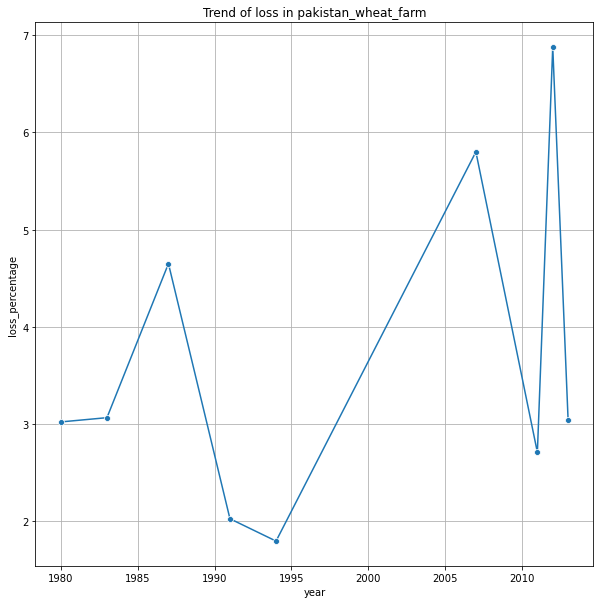

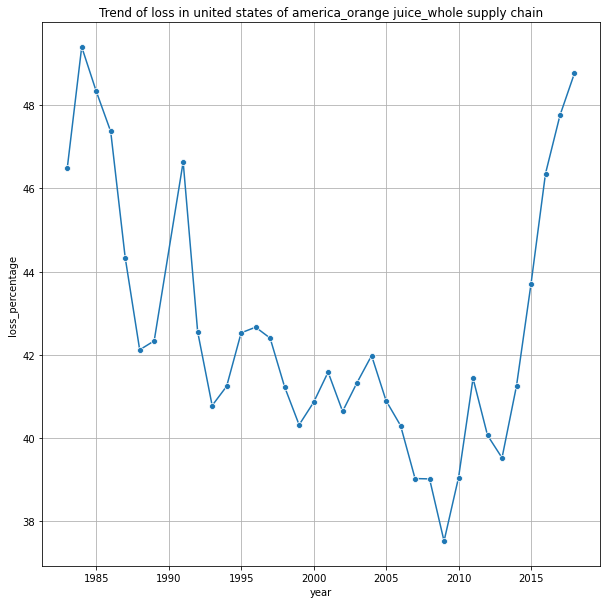

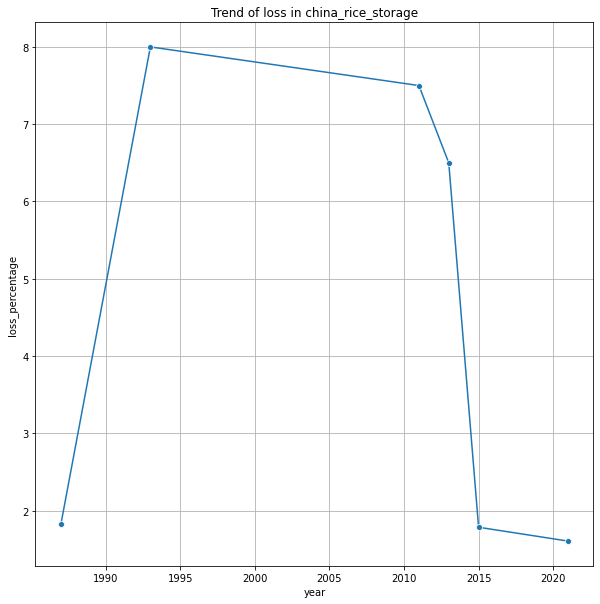

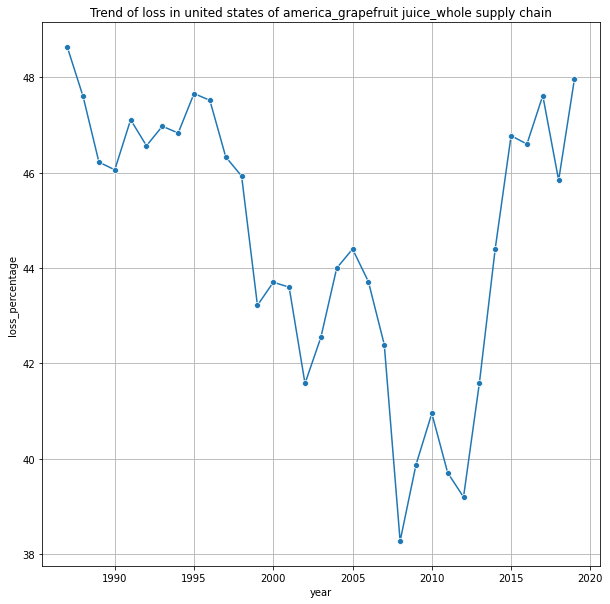

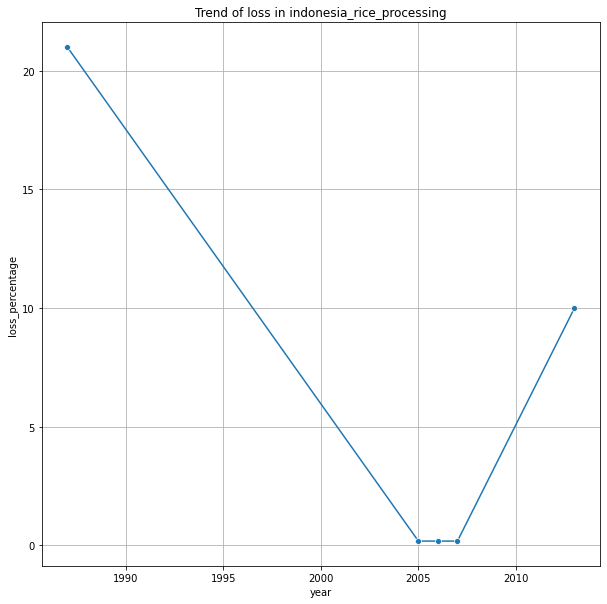

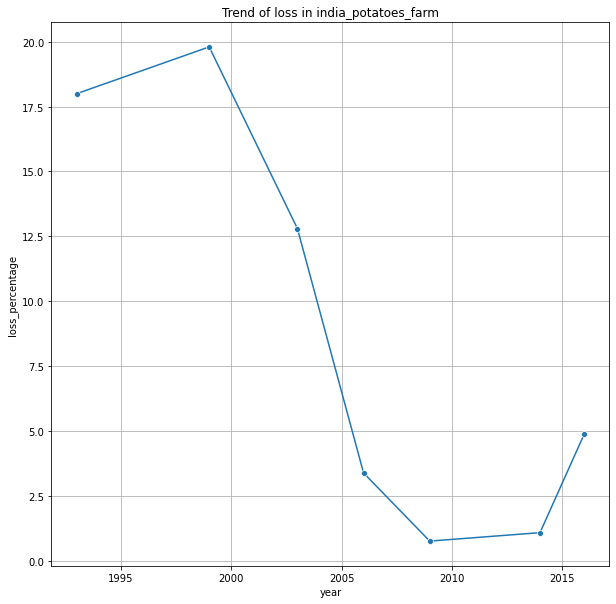

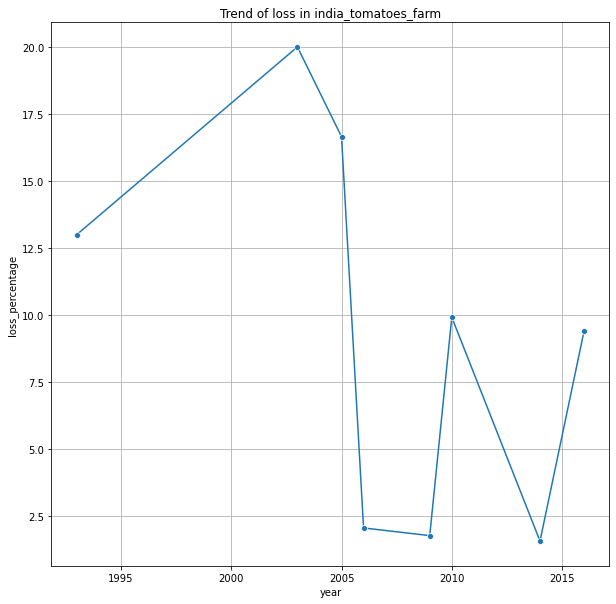

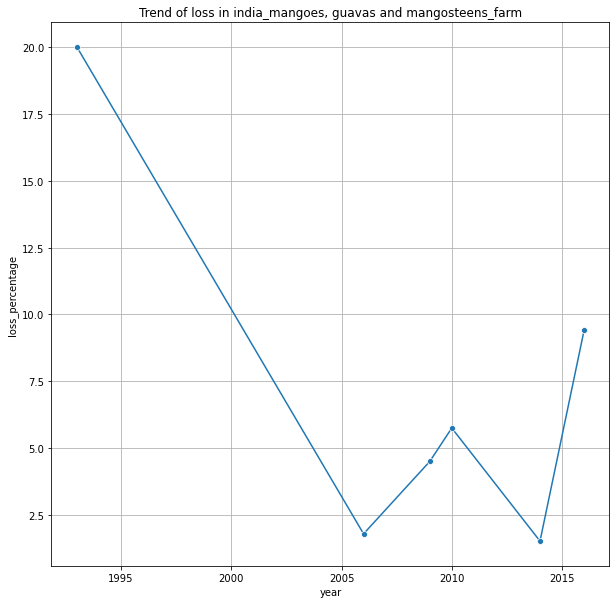

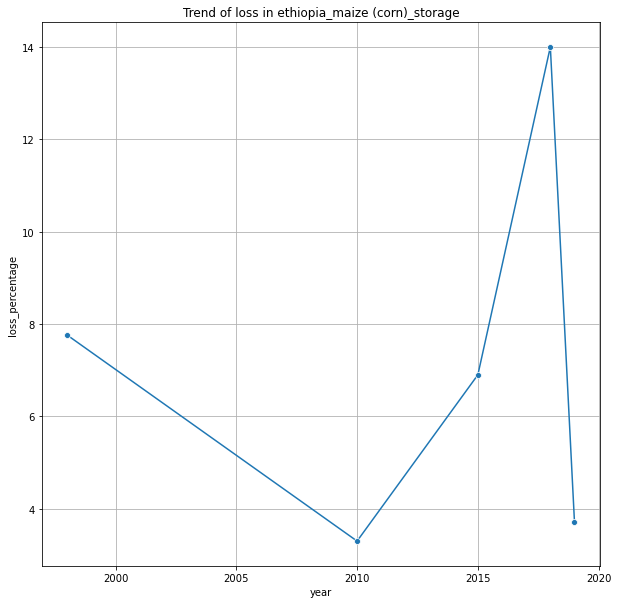

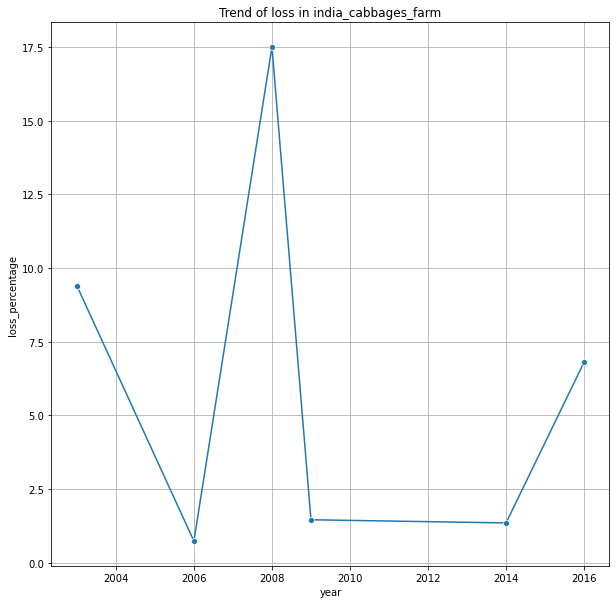

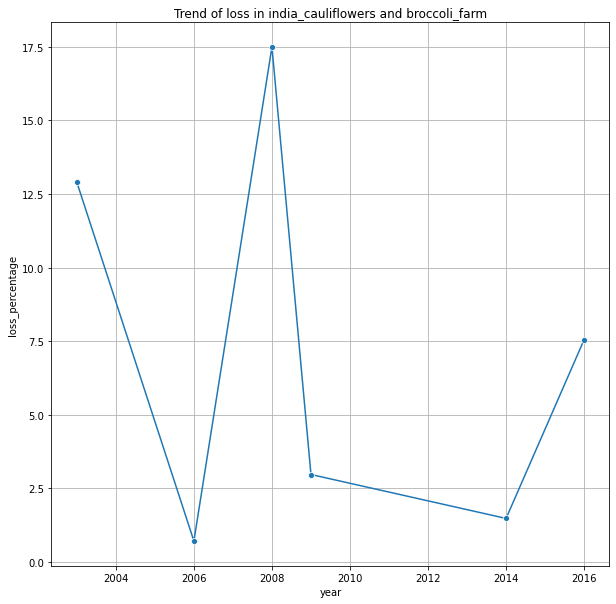

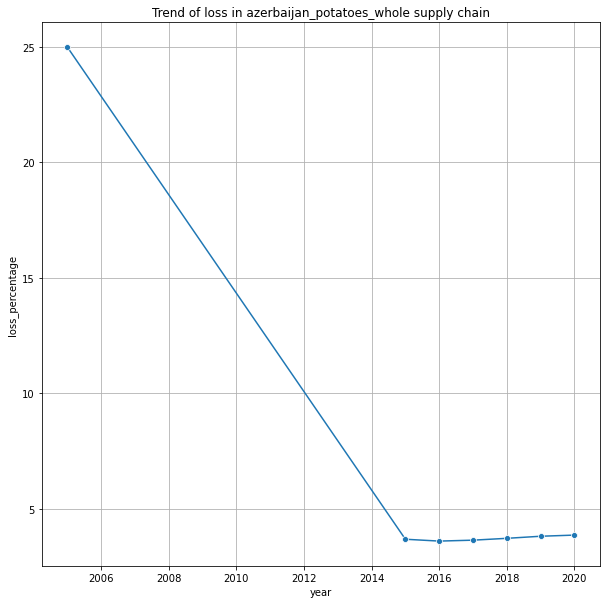

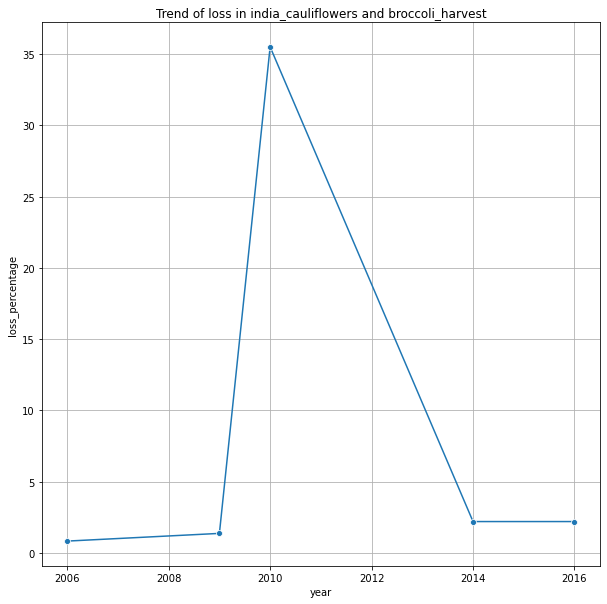

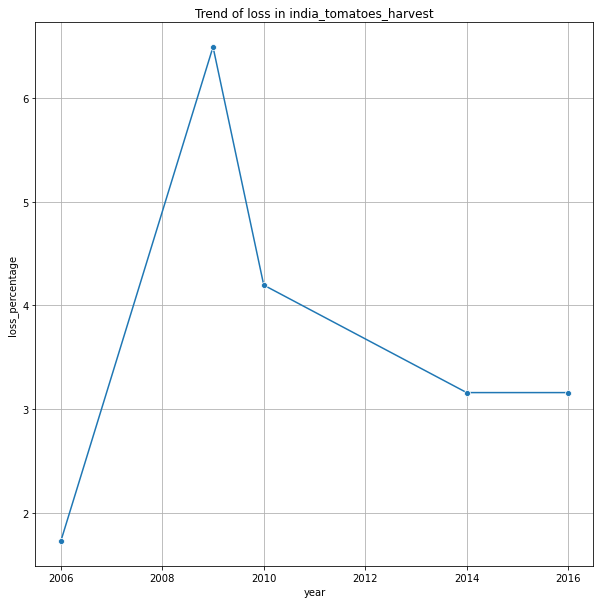

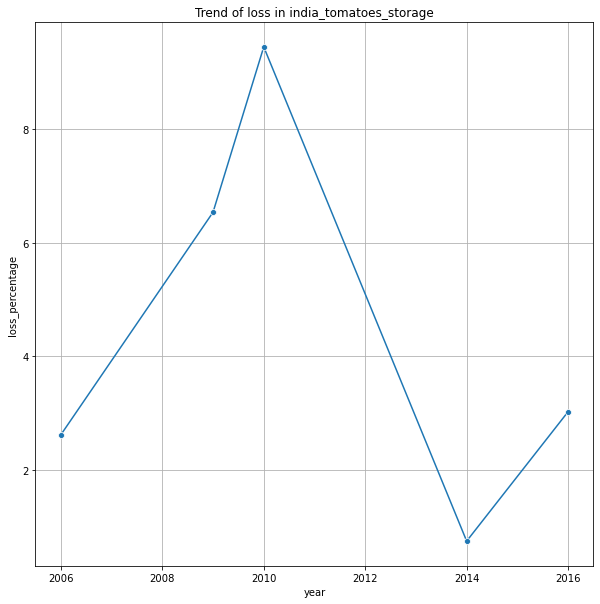

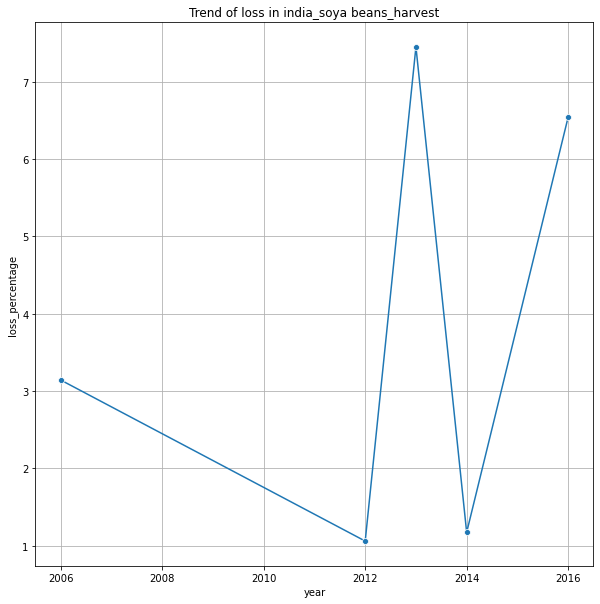

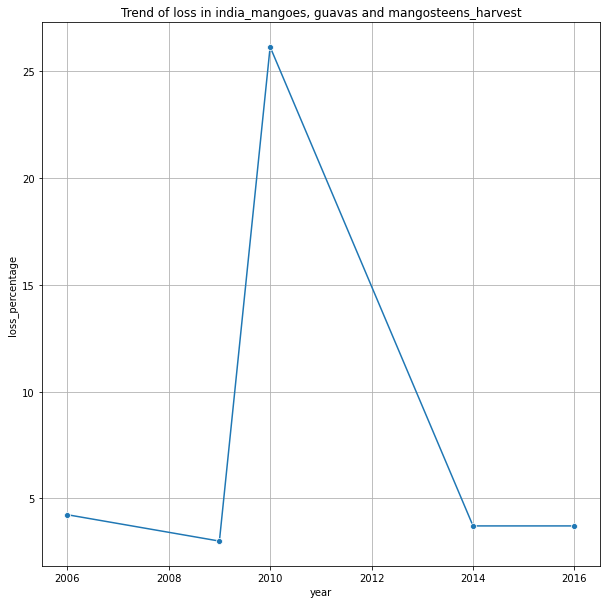

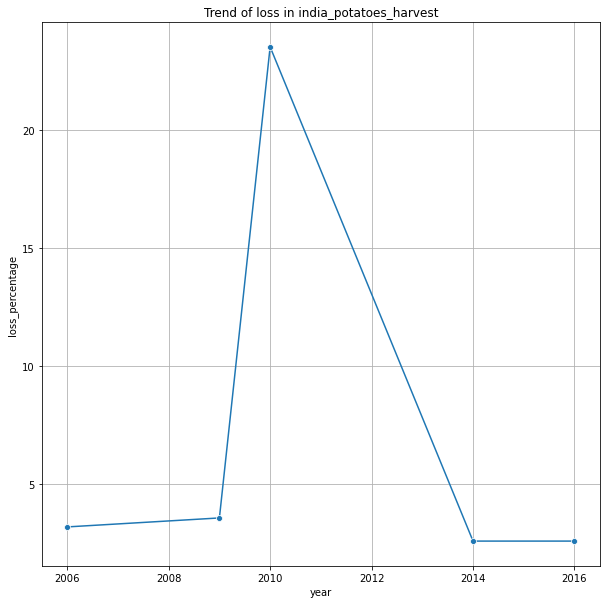

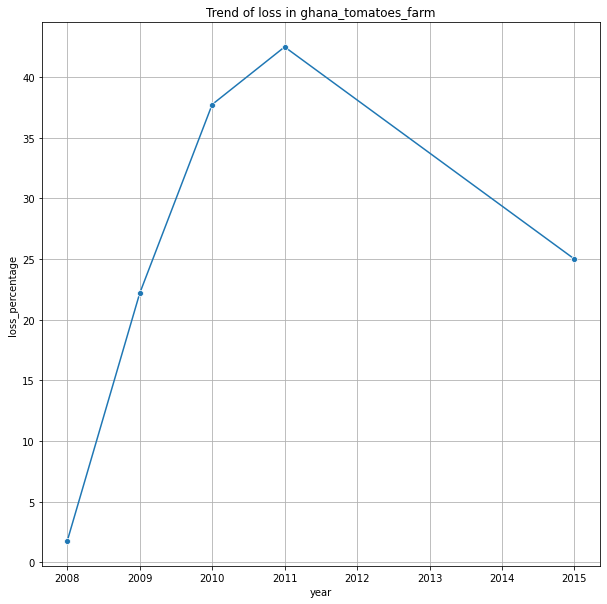

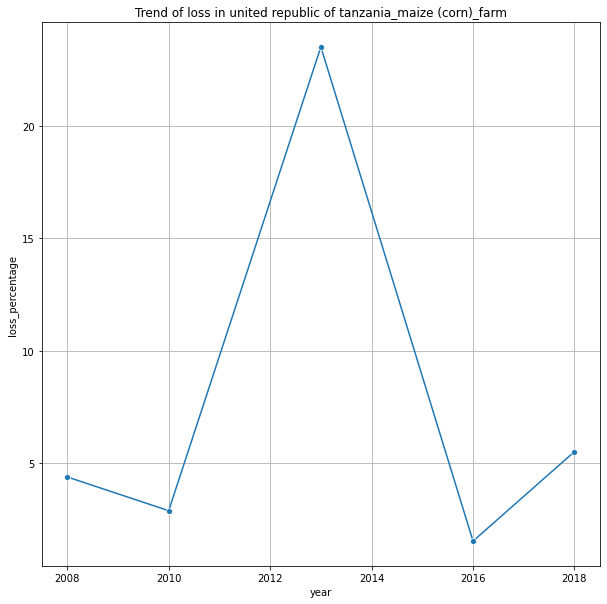

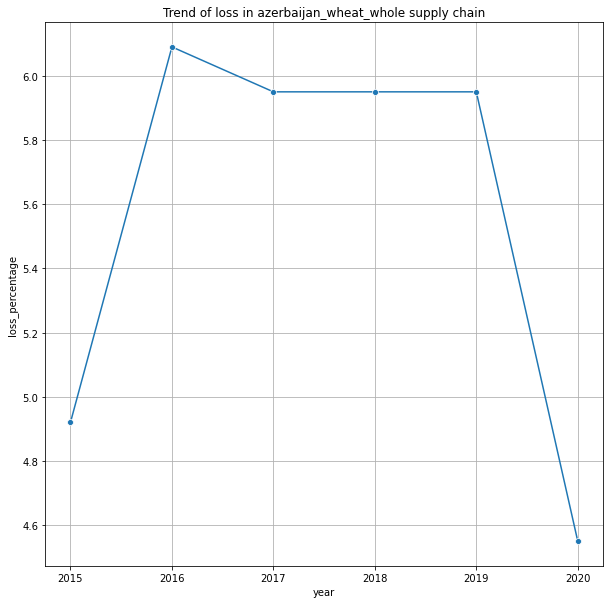

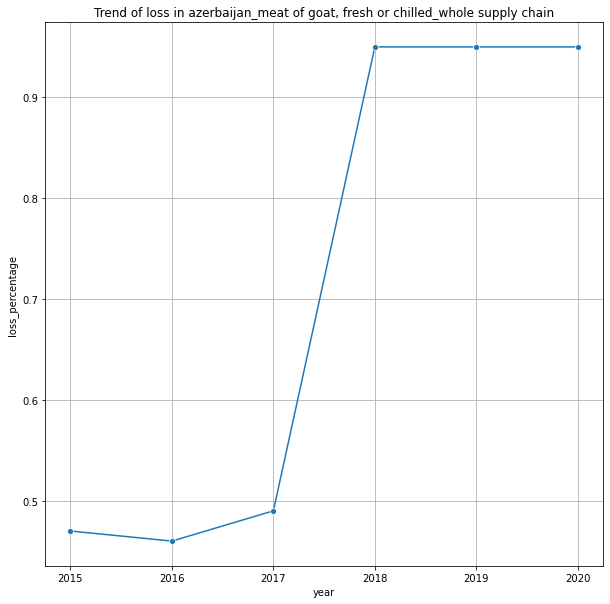

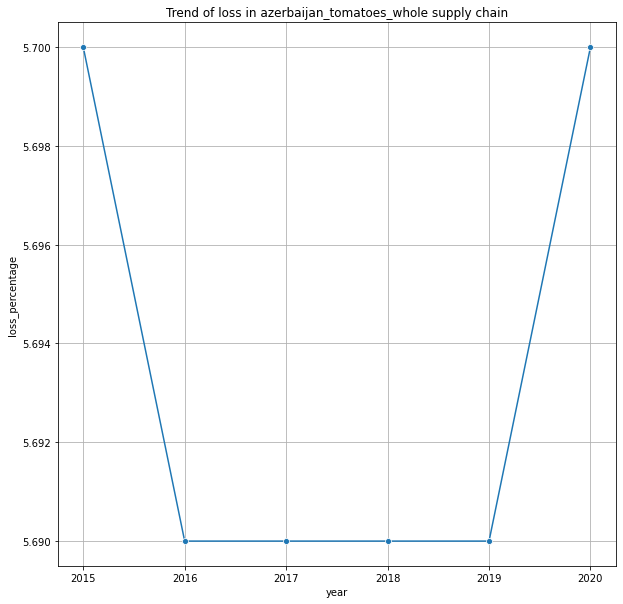

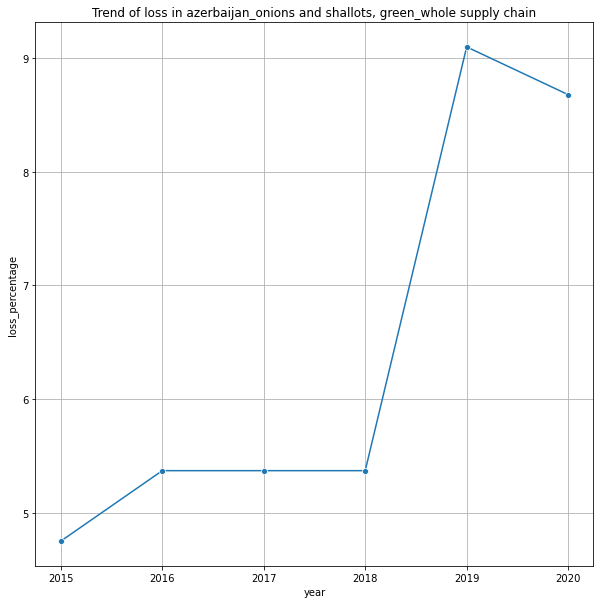

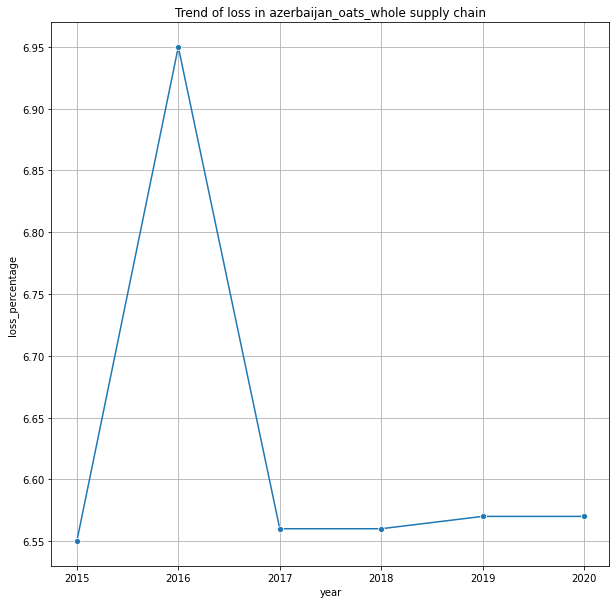

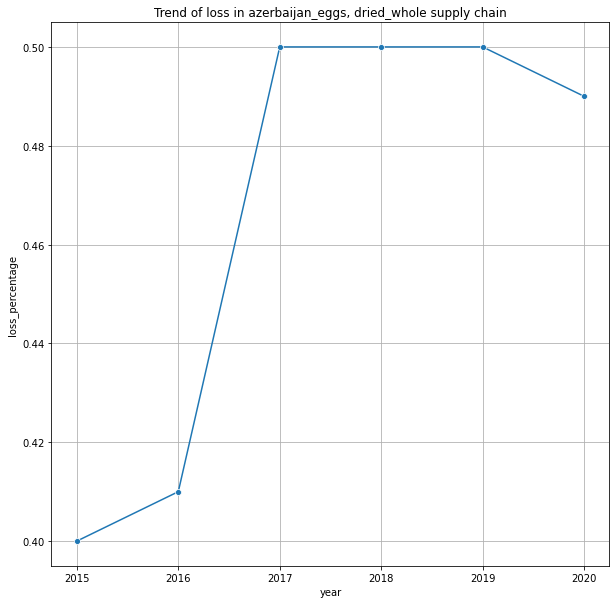

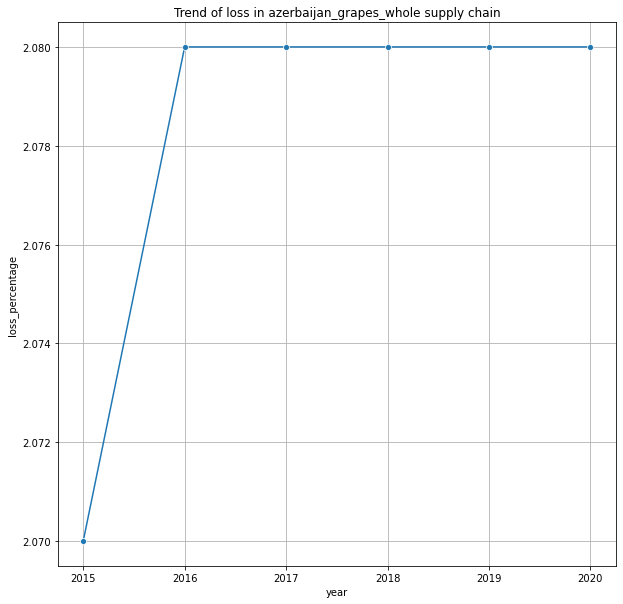

In [23]:
for key in final_reliable_data.main_key.unique():
    key_data = final_reliable_data[final_reliable_data.main_key == key]
    plt.figure(figsize = (10,10))
    plt.title('Trend of loss in '+key)
    sns.lineplot(x = key_data.year, y = key_data.loss_percentage, marker = "o")
    plt.grid()
    plt.show()

#### Plotting for countries

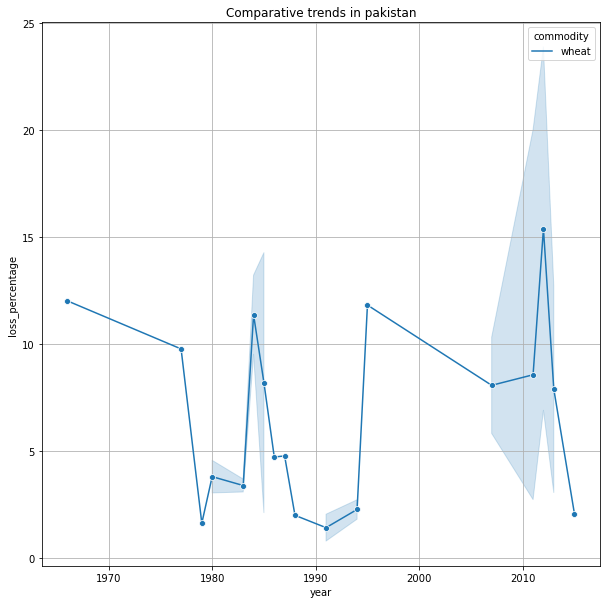

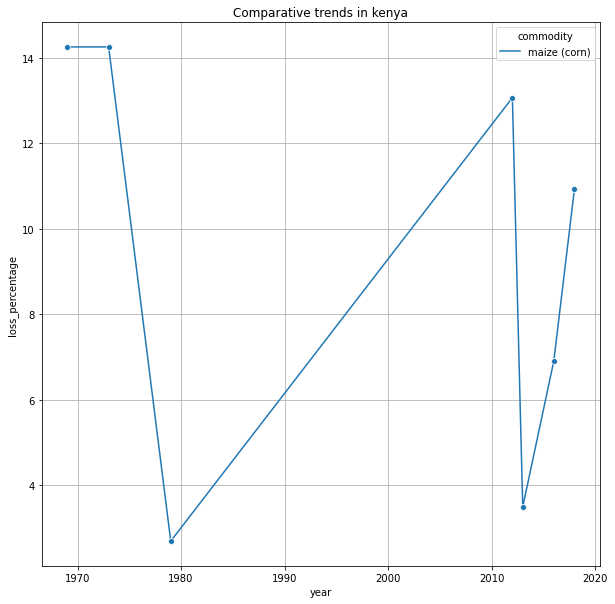

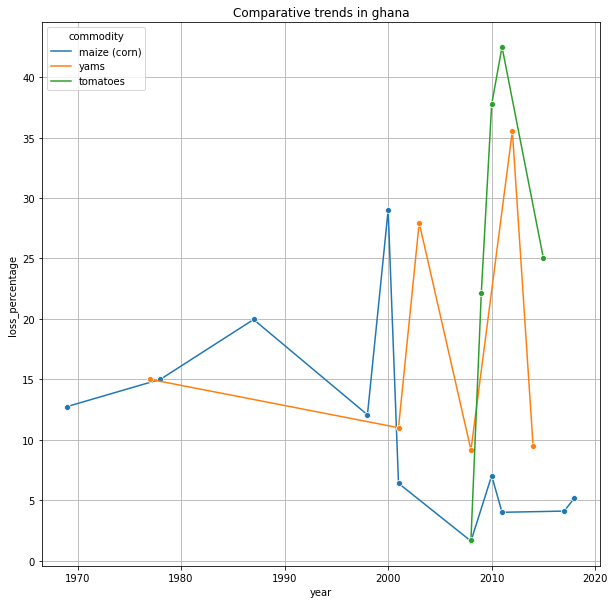

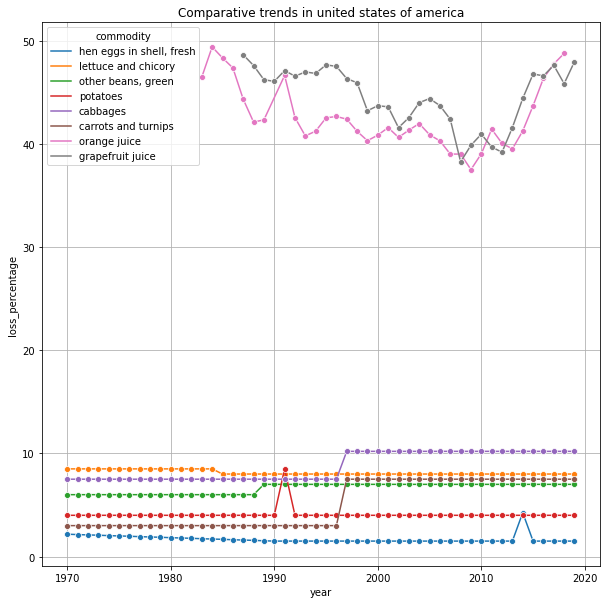

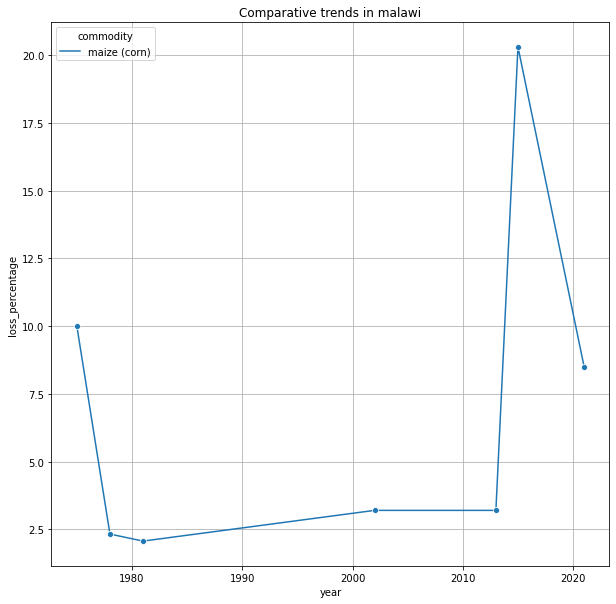

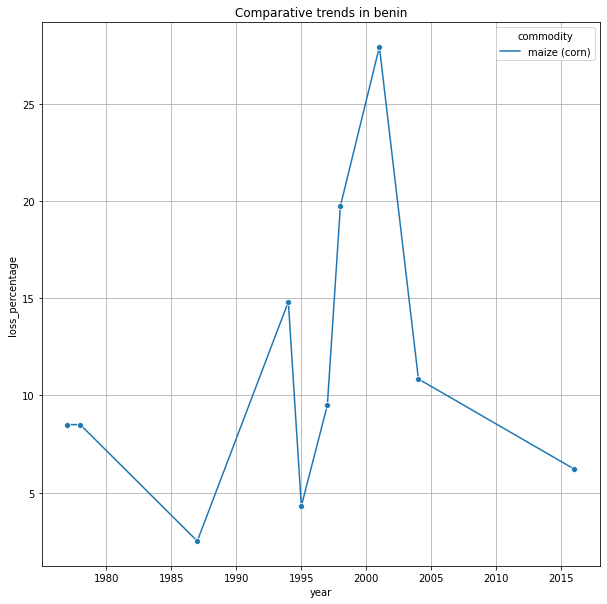

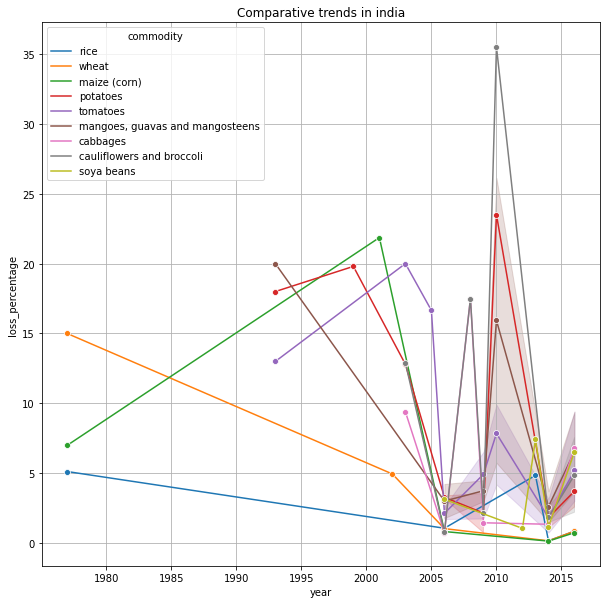

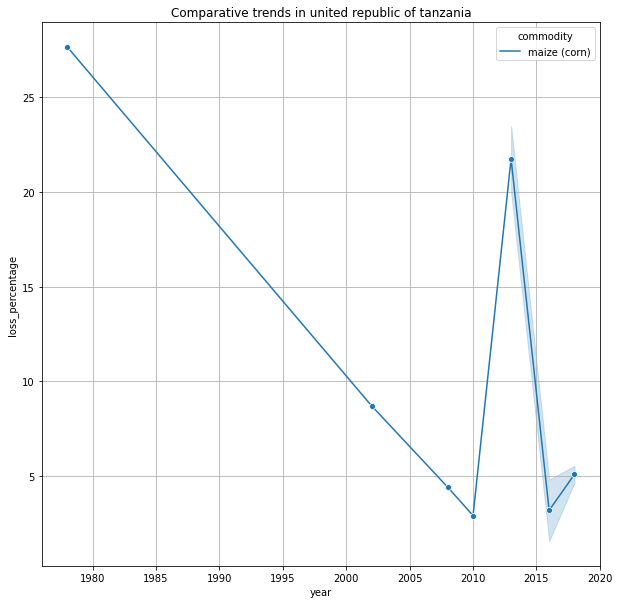

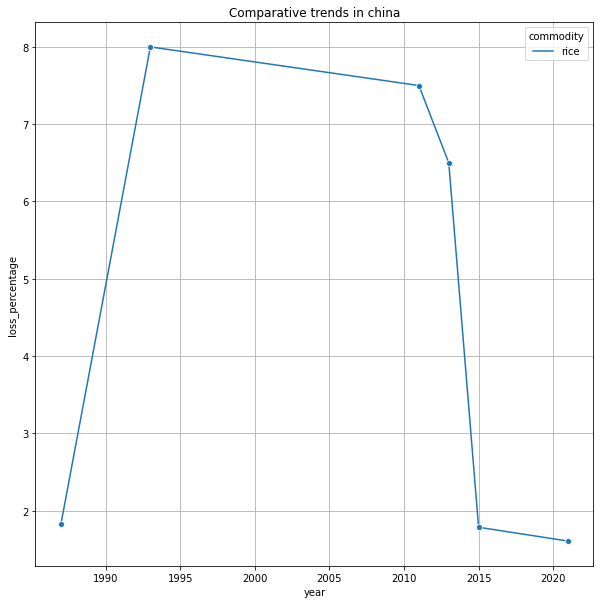

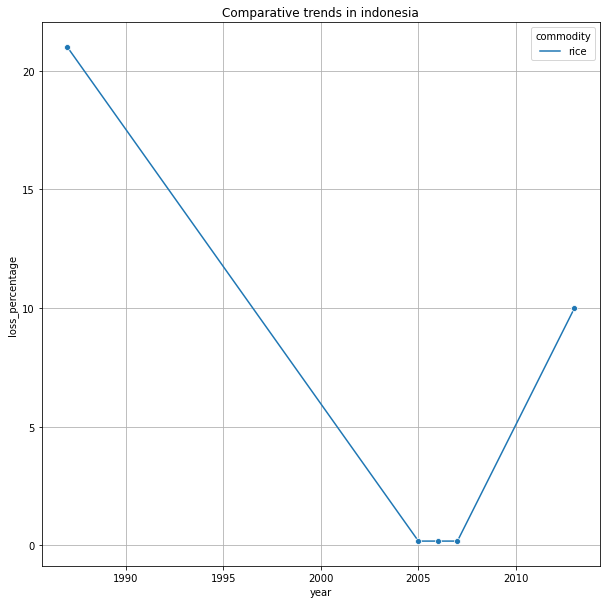

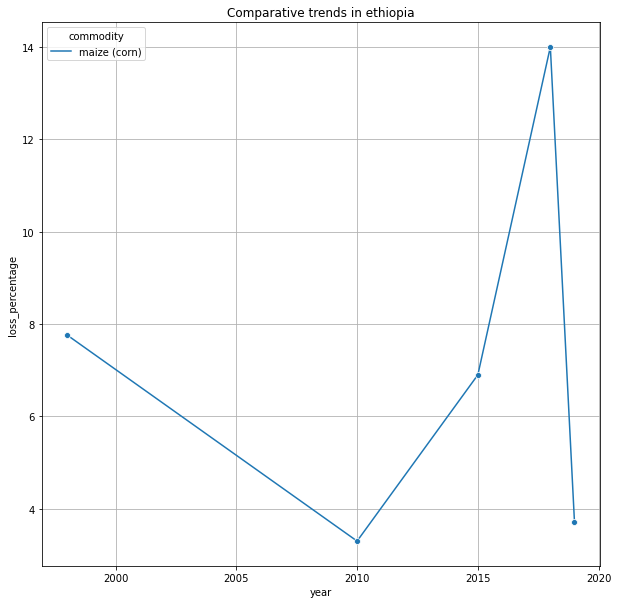

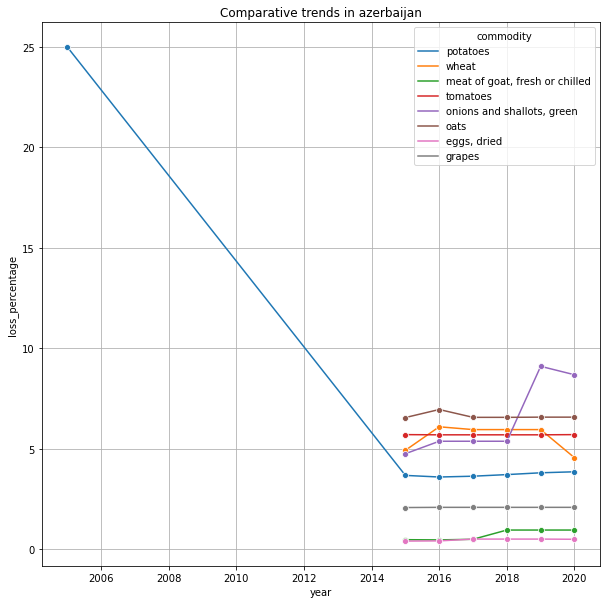

In [24]:
for country in final_reliable_data.country.unique():
    country_data = final_reliable_data[final_reliable_data.country == country]
    plt.figure(figsize = (10,10))
    plt.title('Comparative trends in ' + country)
    sns.lineplot(x = country_data.year, y = country_data.loss_percentage,
            marker = "o", hue = country_data.commodity)
    plt.grid()
    plt.show()

In [25]:
final_reliable_data.sort_values(by = ['year'], ascending = True, inplace = True)

In [26]:
# One-hot encoding country, commodity, and food supply stage

modeling_data = final_reliable_data.copy()

for col in ['country', 'commodity', 'food_supply_stage']:
    modeling_data = modeling_data.join(pd.get_dummies(modeling_data[col])).drop(columns = [col])

In [27]:
# Creating lag features (previous nth value)

modeling_data['loss_lag_1'] = modeling_data.groupby('main_key').loss_percentage.shift(1)
modeling_data['loss_lag_2'] = modeling_data.groupby('main_key').loss_percentage.shift(2)
modeling_data['loss_lag_3'] = modeling_data.groupby('main_key').loss_percentage.shift(3)
modeling_data['loss_lag_4'] = modeling_data.groupby('main_key').loss_percentage.shift(4)
modeling_data['loss_lag_5'] = modeling_data.groupby('main_key').loss_percentage.shift(5)

In [28]:
def weighted_average(x):
    return np.average(x, weights=np.arange(1, len(x) + 1))

In [29]:
# Creating weighted moving average features

for i in tqdm(range(2,6)):
    col_name = 'weighted_rolling_average_loss_'+str(i)
    rolling_averages = []
    keys = []
    years = []
    for key in tqdm(modeling_data.main_key.unique()):
        key_data = modeling_data[modeling_data.main_key == key].reset_index(drop = True)
        rolling_weighted_average = list(key_data.loss_percentage.rolling(i, min_periods = 1).apply(weighted_average, raw = False))
        rolling_averages.append(rolling_weighted_average)
        keys.append([key]*len(rolling_weighted_average))
        years.append(list(key_data.year))

    rolling_averages = sum(rolling_averages,[])
    keys = sum(keys,[])
    years = sum(years,[])

    avg_data = pd.DataFrame({'main_key':keys, 'year':years, col_name:rolling_averages})
    modeling_data = modeling_data.merge(avg_data, on = ['main_key', 'year'], how = 'left')
    modeling_data[col_name] = modeling_data.groupby('main_key')[col_name].shift(1)


100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 948.15it/s]

100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1019.39it/s]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 20.10it/s]


In [30]:
modeling_data.shape

(598, 51)

#### XGBoost model

In [31]:
trainable_data = modeling_data.drop(columns = ['loss_percentage','cause_of_loss'])
target = modeling_data[['main_key', 'year', 'loss_percentage']]

# trainable_data.fillna(-999,inplace = True)

xtrain, ytrain = trainable_data[trainable_data.year < 2012].reset_index(drop = True), target[target.year < 2012].loss_percentage
xval, yval = trainable_data[(trainable_data.year >= 2012) &
                           (trainable_data.year < 2017)].reset_index(drop = True), target[(target.year >= 2012) &
                                                                                         (target.year < 2017)].loss_percentage
xtest, ytest = trainable_data[trainable_data.year >= 2017].reset_index(drop = True), target[target.year >= 2017].loss_percentage

In [32]:
print(xtrain.shape, xval.shape, xtest.shape)
print(len(ytrain), len(yval), len(ytest))

(425, 49) (109, 49) (64, 49)
425 109 64


In [33]:
params = {"objective":"reg:linear",
          "booster":"gbtree",
          "eta":0.01,
          "max_depth": 8,
         "subsample":0.95,
         "silent":1,
         "seed":1,
         "lambda":0.01,
         "alpha":0.01,
         "eval_metric":"rmse"}

In [34]:
num_boost_round = 1000

dtrain = xgb.DMatrix(xtrain.drop(columns = ['main_key']), ytrain)
dvalid = xgb.DMatrix(xval.drop(columns = ['main_key']), yval)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

booster = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = 25)

[0]	train-rmse:13.11903	eval-rmse:12.12354
[1]	train-rmse:12.99786	eval-rmse:12.05338
[2]	train-rmse:12.87769	eval-rmse:11.98615
[3]	train-rmse:12.75933	eval-rmse:11.91644
[4]	train-rmse:12.64261	eval-rmse:11.84877
[5]	train-rmse:12.52661	eval-rmse:11.78817
[6]	train-rmse:12.40984	eval-rmse:11.70933
[7]	train-rmse:12.29571	eval-rmse:11.64643
[8]	train-rmse:12.18334	eval-rmse:11.58773
[9]	train-rmse:12.07277	eval-rmse:11.53181
[10]	train-rmse:11.96303	eval-rmse:11.46414
[11]	train-rmse:11.85204	eval-rmse:11.39130
[12]	train-rmse:11.73877	eval-rmse:11.30646
[13]	train-rmse:11.63206	eval-rmse:11.25195
[14]	train-rmse:11.52076	eval-rmse:11.17617
[15]	train-rmse:11.41423	eval-rmse:11.10750
[16]	train-rmse:11.30856	eval-rmse:11.04084
[17]	train-rmse:11.20648	eval-rmse:10.99027
[18]	train-rmse:11.10587	eval-rmse:10.92745
[19]	train-rmse:11.00463	eval-rmse:10.85409
[20]	train-rmse:10.90584	eval-rmse:10.80393
[21]	train-rmse:10.80342	eval-rmse:10.73353
[22]	train-rmse:10.70455	eval-rmse:10.6879

[192]	train-rmse:2.63689	eval-rmse:7.48510
[193]	train-rmse:2.62145	eval-rmse:7.48258
[194]	train-rmse:2.60455	eval-rmse:7.48267
[195]	train-rmse:2.58543	eval-rmse:7.48327
[196]	train-rmse:2.57181	eval-rmse:7.48932
[197]	train-rmse:2.54885	eval-rmse:7.48787
[198]	train-rmse:2.53177	eval-rmse:7.49392
[199]	train-rmse:2.51667	eval-rmse:7.49536
[200]	train-rmse:2.49726	eval-rmse:7.48889
[201]	train-rmse:2.47847	eval-rmse:7.48332
[202]	train-rmse:2.45693	eval-rmse:7.48291
[203]	train-rmse:2.43522	eval-rmse:7.48488
[204]	train-rmse:2.41507	eval-rmse:7.48219
[205]	train-rmse:2.39440	eval-rmse:7.48177
[206]	train-rmse:2.37357	eval-rmse:7.49112
[207]	train-rmse:2.35705	eval-rmse:7.48679
[208]	train-rmse:2.33764	eval-rmse:7.48235
[209]	train-rmse:2.32149	eval-rmse:7.47828
[210]	train-rmse:2.30271	eval-rmse:7.47304
[211]	train-rmse:2.28575	eval-rmse:7.46830
[212]	train-rmse:2.26772	eval-rmse:7.46764
[213]	train-rmse:2.25550	eval-rmse:7.47541
[214]	train-rmse:2.24220	eval-rmse:7.47552
[215]	train

In [35]:
train_predictions = booster.predict(xgb.DMatrix(xtrain.drop(columns = ['main_key'])))
val_predictions = booster.predict(xgb.DMatrix(xval.drop(columns = ['main_key'])))
test_predictions = booster.predict(xgb.DMatrix(xtest.drop(columns = ['main_key'])))

In [36]:
print(f'Training RMSE = {np.round(np.sqrt(mean_squared_error(train_predictions, ytrain)),2)} | MAPE = {np.round(100*mean_absolute_percentage_error(train_predictions, ytrain),2)}% | R-squared = {np.round(r2_score(train_predictions, ytrain),2)}')
print(f'Validation RMSE = {np.round(np.sqrt(mean_squared_error(val_predictions, yval)),2)} | MAPE = {np.round(100*mean_absolute_percentage_error(val_predictions, yval),2)}% | R-squared = {np.round(r2_score(val_predictions, yval),2)}')
print(f'Test RMSE = {np.round(np.sqrt(mean_squared_error(test_predictions, ytest)),2)} | MAPE = {np.round(100*mean_absolute_percentage_error(test_predictions, ytest),2)}% | R-squared = {np.round(r2_score(test_predictions, ytest),2)}')

Training RMSE = 1.95 | MAPE = 18.59% | R-squared = 0.97
Validation RMSE = 7.54 | MAPE = 52.49% | R-squared = 0.33
Test RMSE = 5.61 | MAPE = 41.01% | R-squared = 0.66


Result analysis

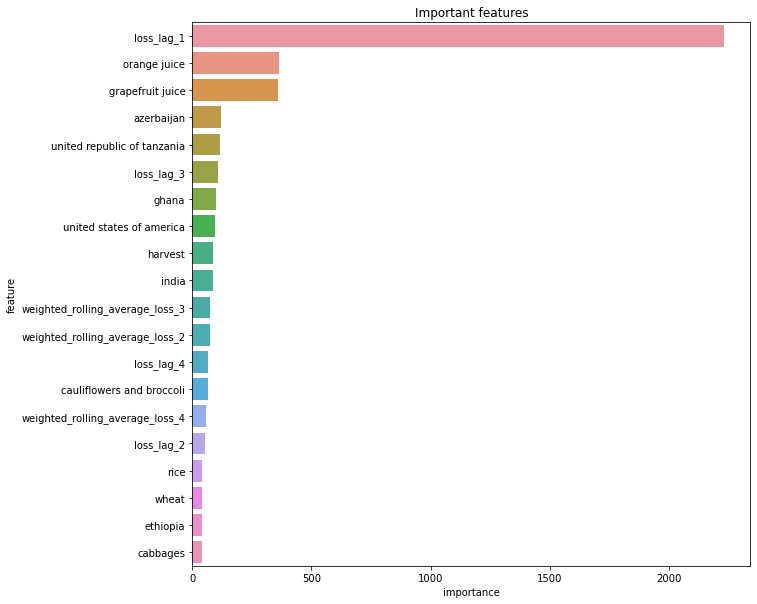

In [46]:
feat_imp = pd.DataFrame(list(booster.get_score(importance_type = 'gain').items()), columns = ['feature', 'importance']).sort_values('importance', ascending=False).iloc[:20,:]

plt.figure(figsize = (10,10))
sns.barplot(x="importance", y="feature", data=feat_imp.sort_values(by="importance", ascending=False))
plt.title('Important features')
plt.show()

In [37]:
all_predictions = np.concatenate([train_predictions, val_predictions, test_predictions])

In [38]:
len(all_predictions)

598

In [39]:
modeling_data['predictions'] = all_predictions

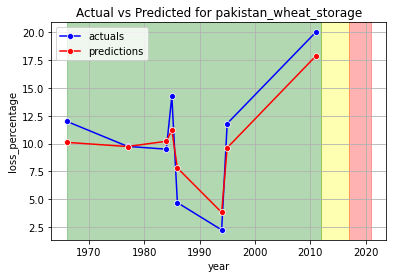

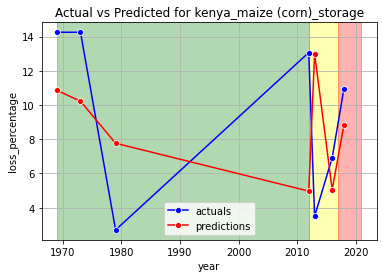

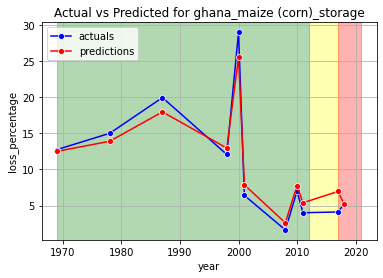

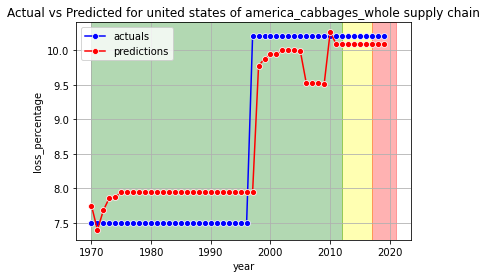

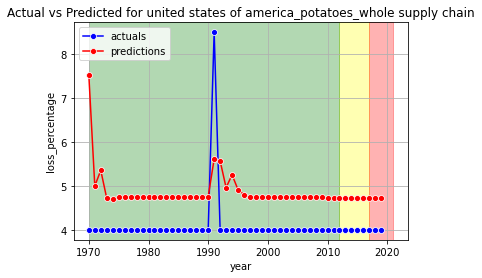

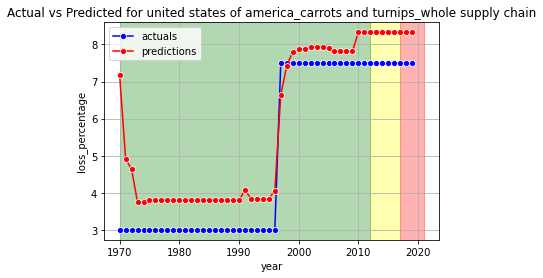

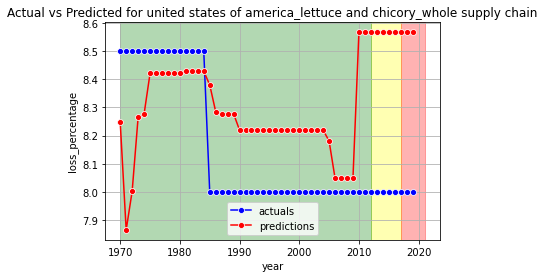

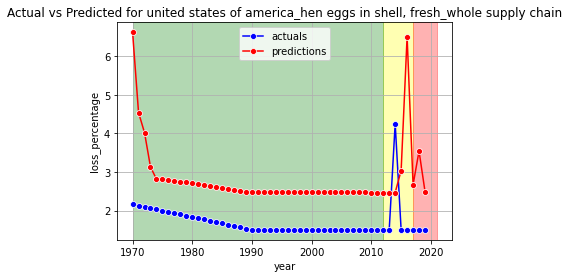

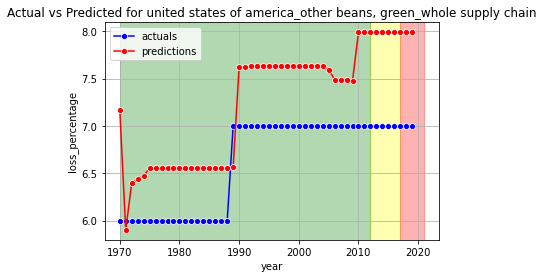

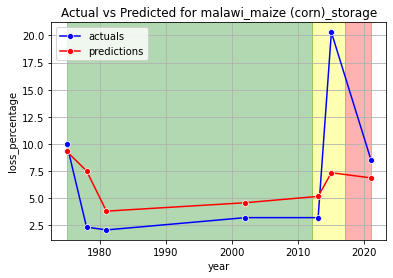

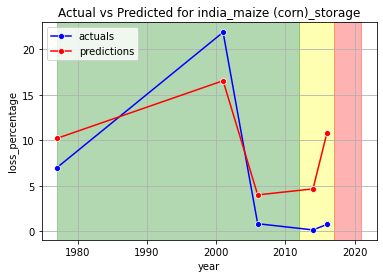

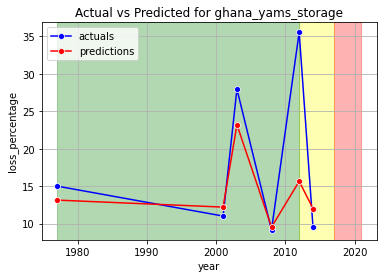

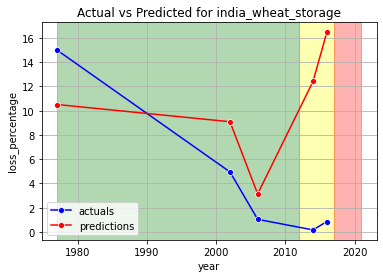

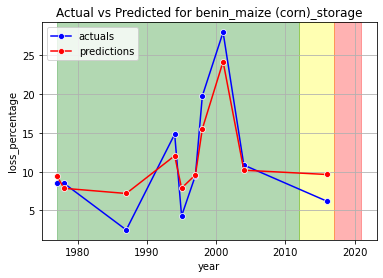

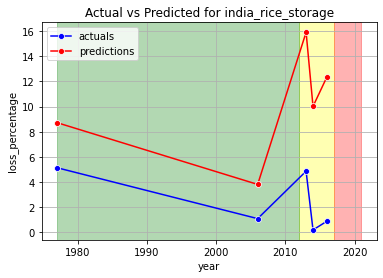

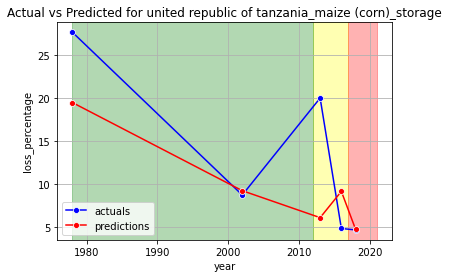

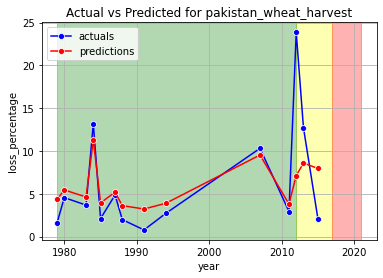

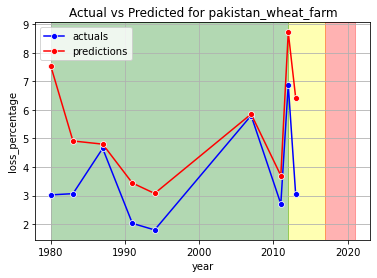

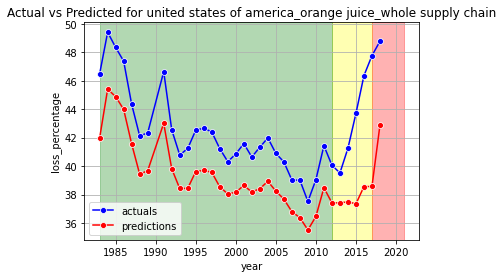

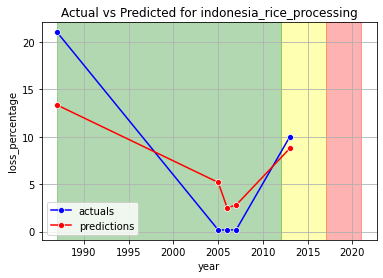

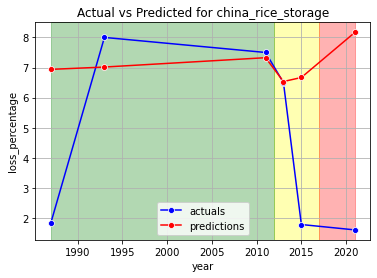

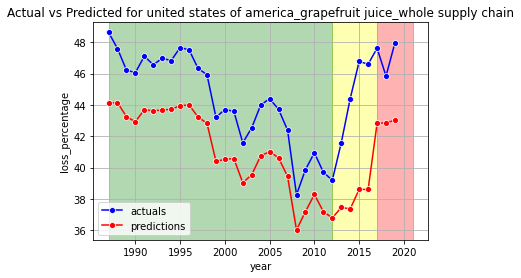

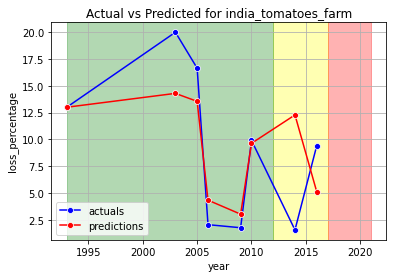

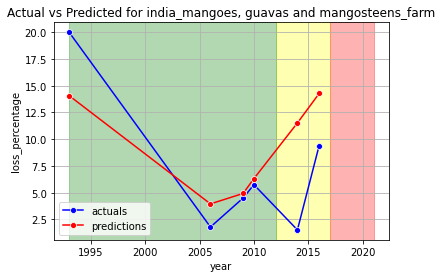

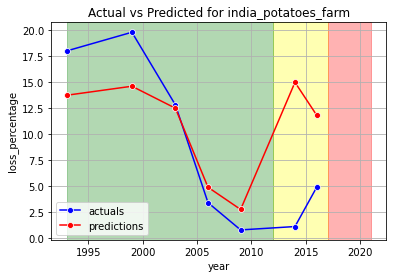

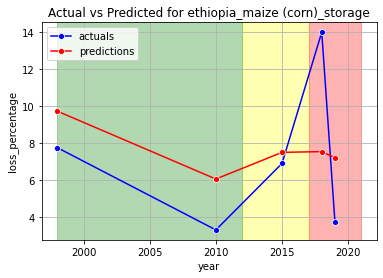

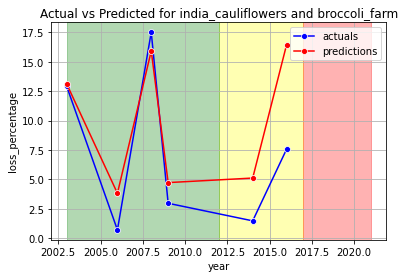

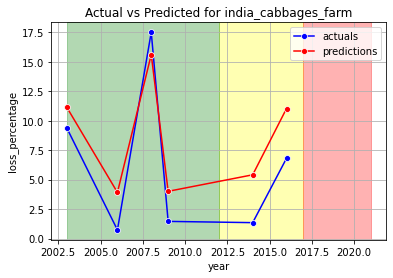

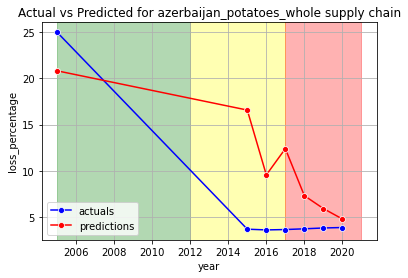

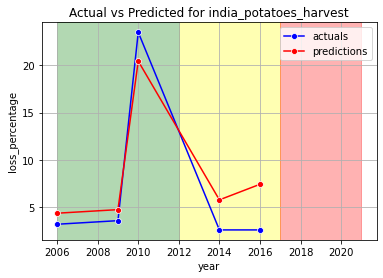

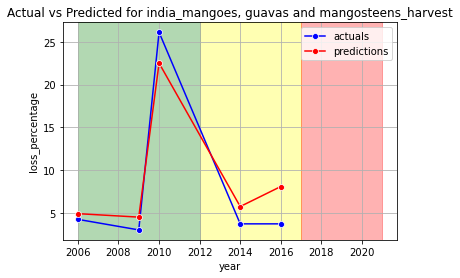

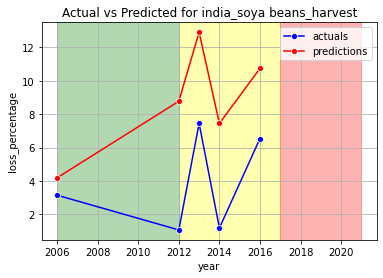

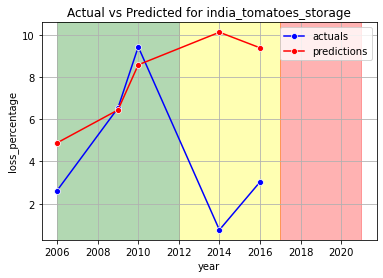

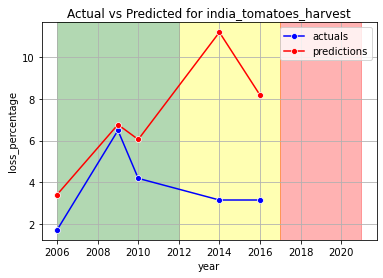

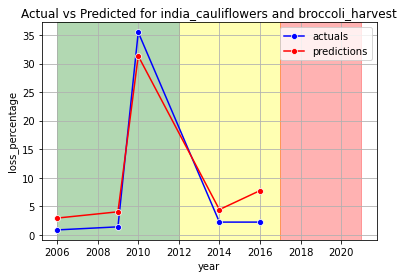

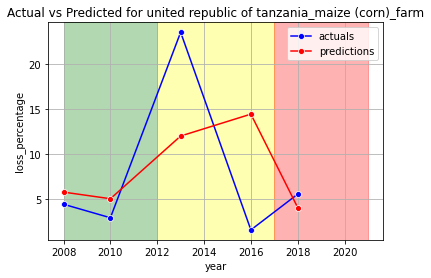

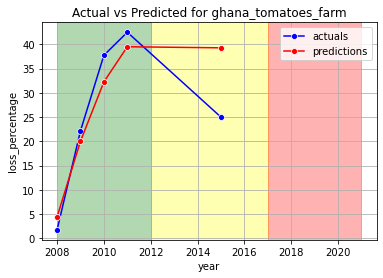

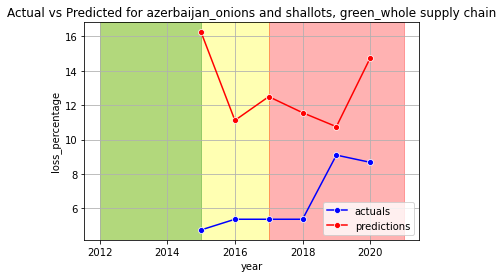

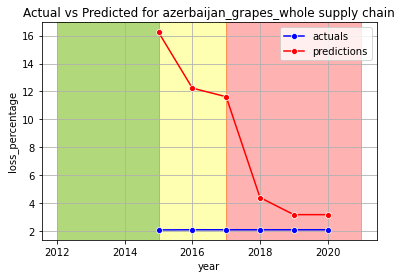

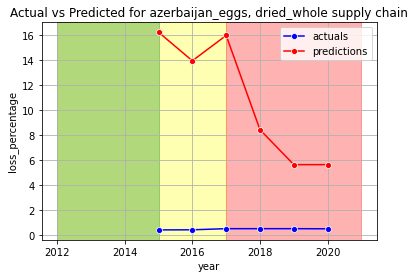

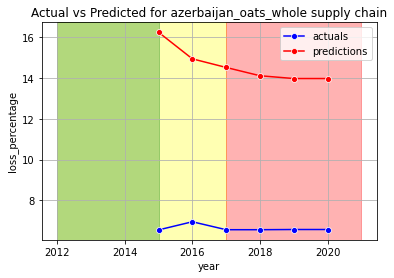

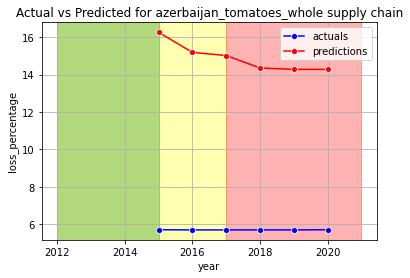

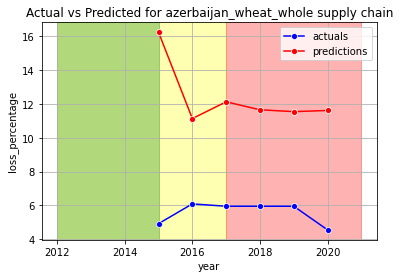

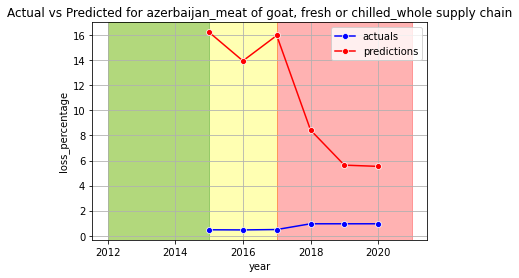

In [40]:
# Plotting actual vs predicted for all keys and all sets

for key in modeling_data.main_key.unique():
  key_data = modeling_data[modeling_data.main_key == key]
  plt.title(f'Actual vs Predicted for {key}')
  ax = sns.lineplot(x = key_data.year, y = key_data.loss_percentage,
               marker = "o", label = 'actuals', color = "blue")
  ax = sns.lineplot(x = key_data.year, y = key_data.predictions,
               marker = "o", label = 'predictions', color = "red")
  ax.axvspan(2012, 2017, alpha=0.3, color = 'yellow', label = 'train')
  ax.axvspan(min(key_data.year),2012, alpha=0.3, color = 'green', label = 'val')
  ax.axvspan(2017, 2021, alpha=0.3, color = 'red', label = 'test')
  plt.grid()
  plt.show()

### State-space models

In [41]:
modeling_data.shape

(598, 52)

In [42]:
modeling_data.main_key.nunique()

44

In [43]:
# Converting all series to a numpy array

time_series_data = dict()

for key in modeling_data.main_key.unique():
    time_series_data[key] = list(modeling_data[modeling_data.main_key == key].loss_percentage)

In [47]:
# Defining our structural time series model components
def build_model(observed_time_series):
    trend = tfp.sts.LocalLinearTrend(observed_time_series = observed_time_series)
    arima = tfp.sts.AutoregressiveIntegratedMovingAverage(3,3,
    integration_degree=1,
    observed_time_series=observed_time_series)
    model = tfp.sts.Sum([arima, trend], observed_time_series=observed_time_series)
    return model

  0%|          | 0/44 [00:00<?, ?it/s]

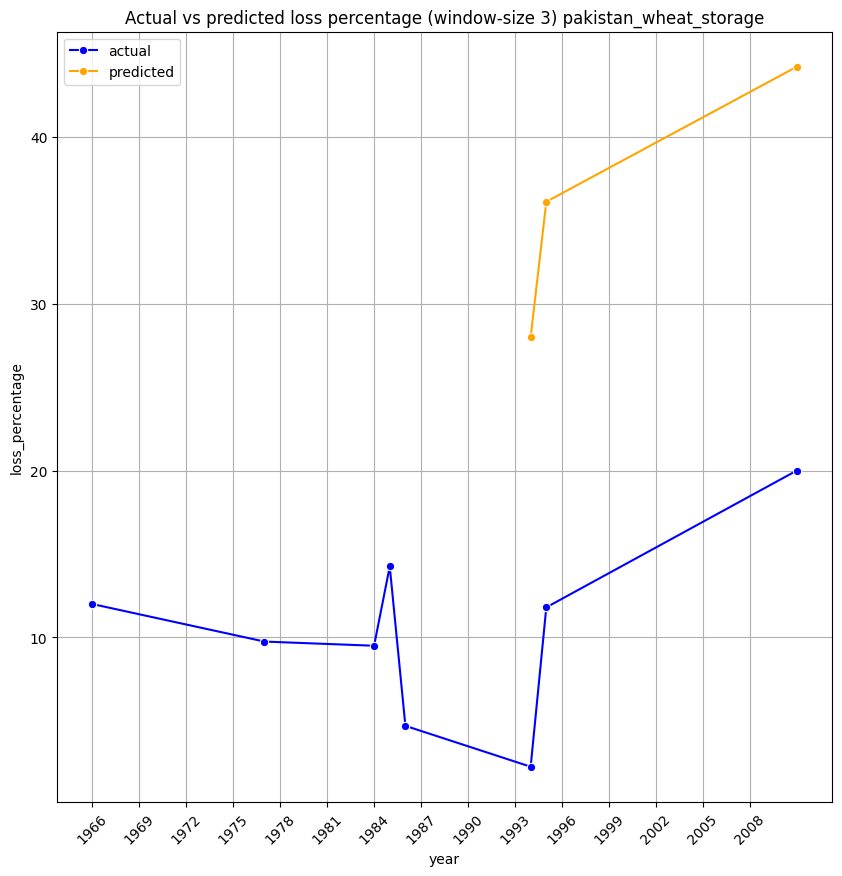

  2%|▏         | 1/44 [00:28<20:07, 28.07s/it]

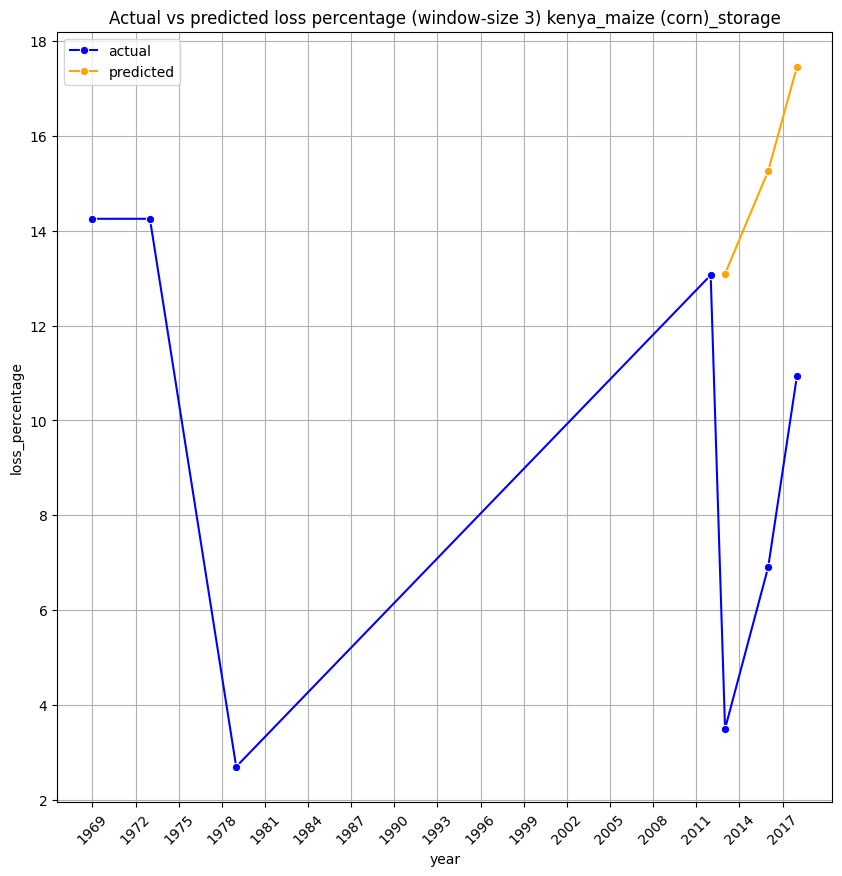

  5%|▍         | 2/44 [00:58<20:39, 29.52s/it]

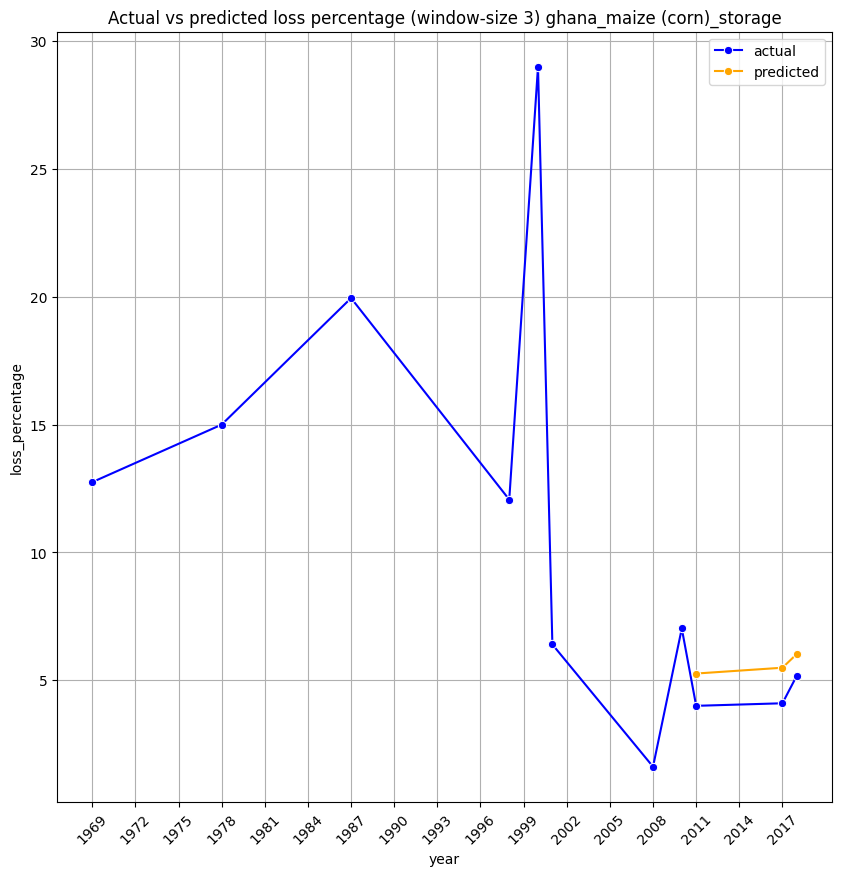

  7%|▋         | 3/44 [01:31<21:10, 30.98s/it]

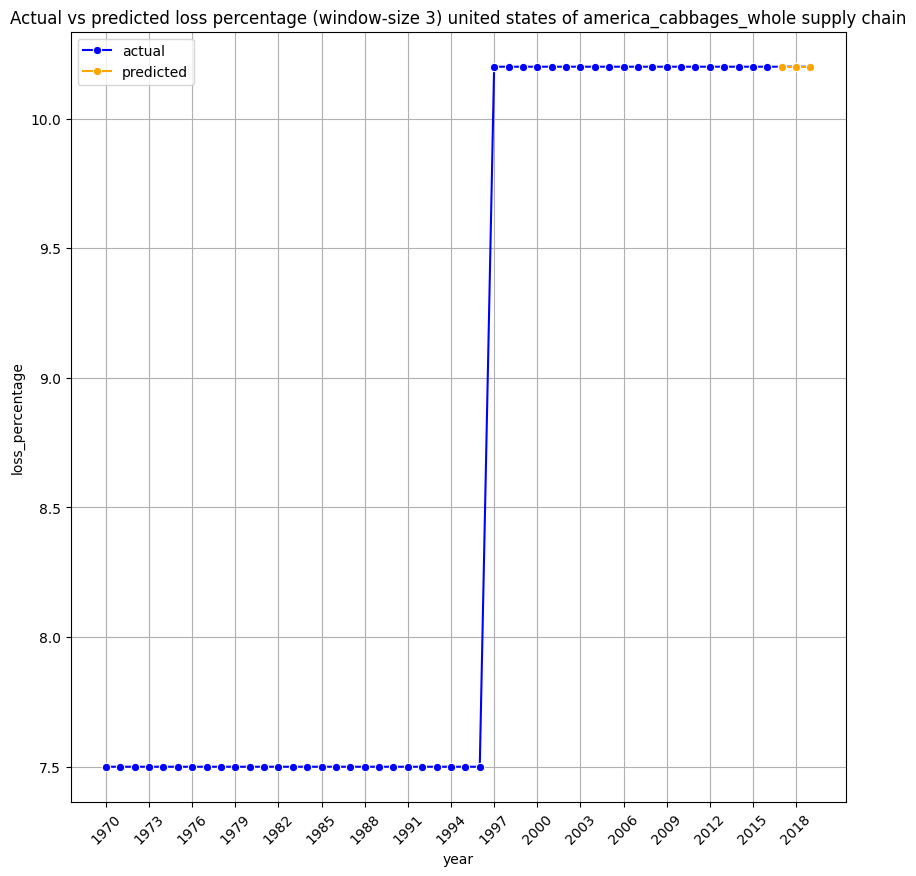

  9%|▉         | 4/44 [02:02<20:37, 30.94s/it]

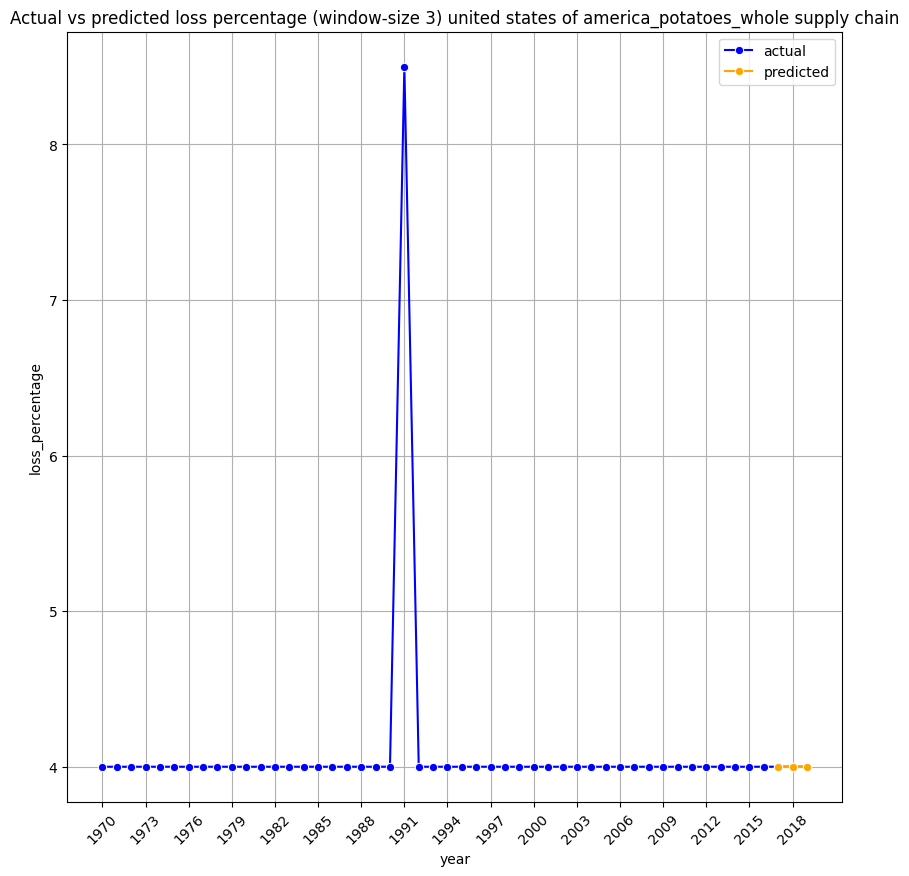

 11%|█▏        | 5/44 [02:33<20:07, 30.95s/it]

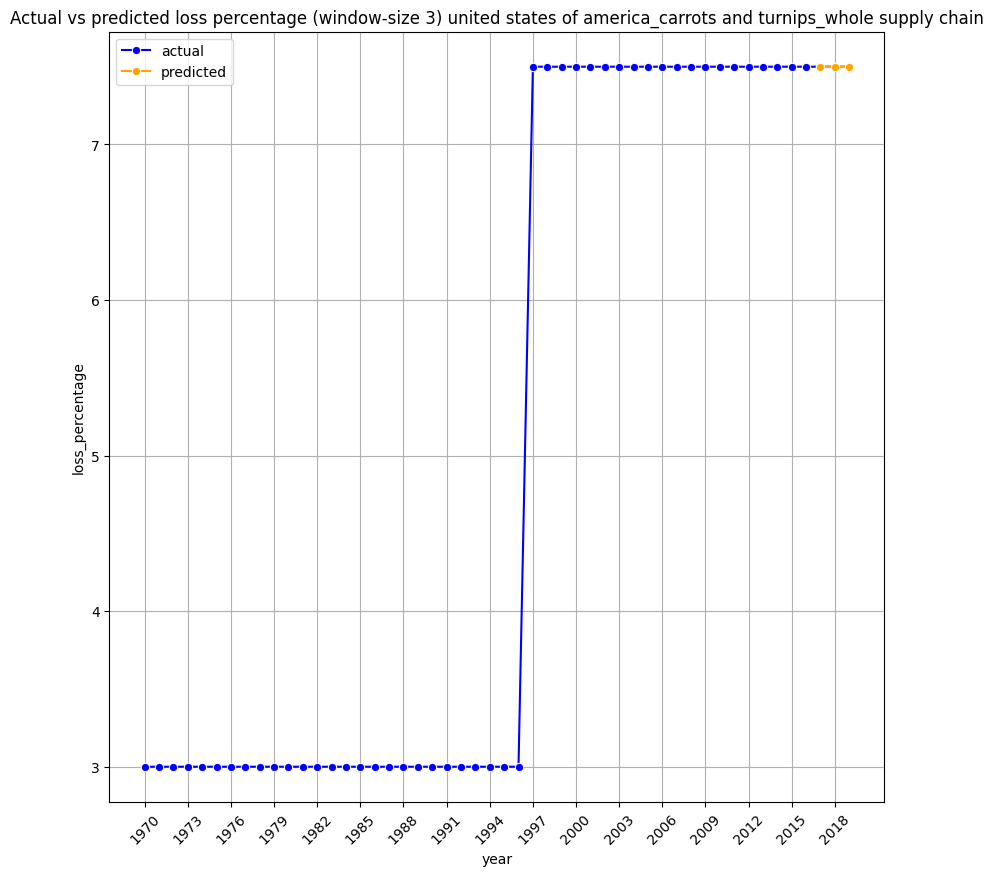

 14%|█▎        | 6/44 [03:06<20:08, 31.81s/it]

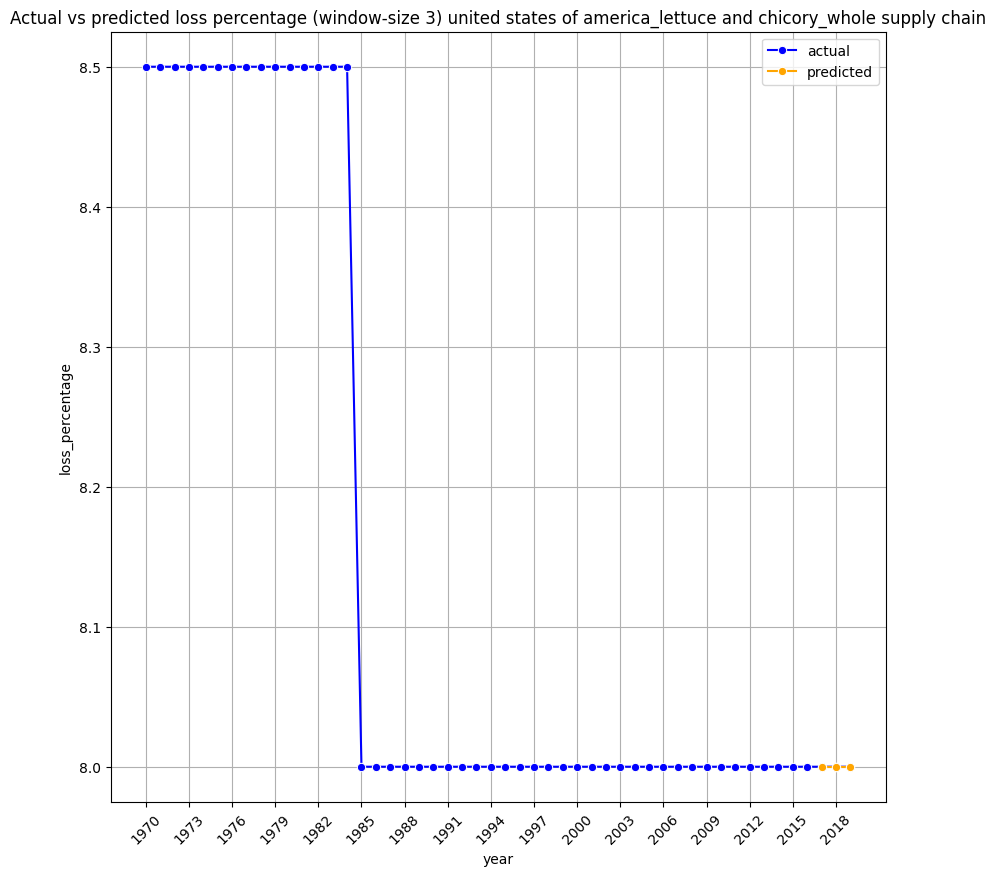

 16%|█▌        | 7/44 [03:42<20:20, 32.98s/it]

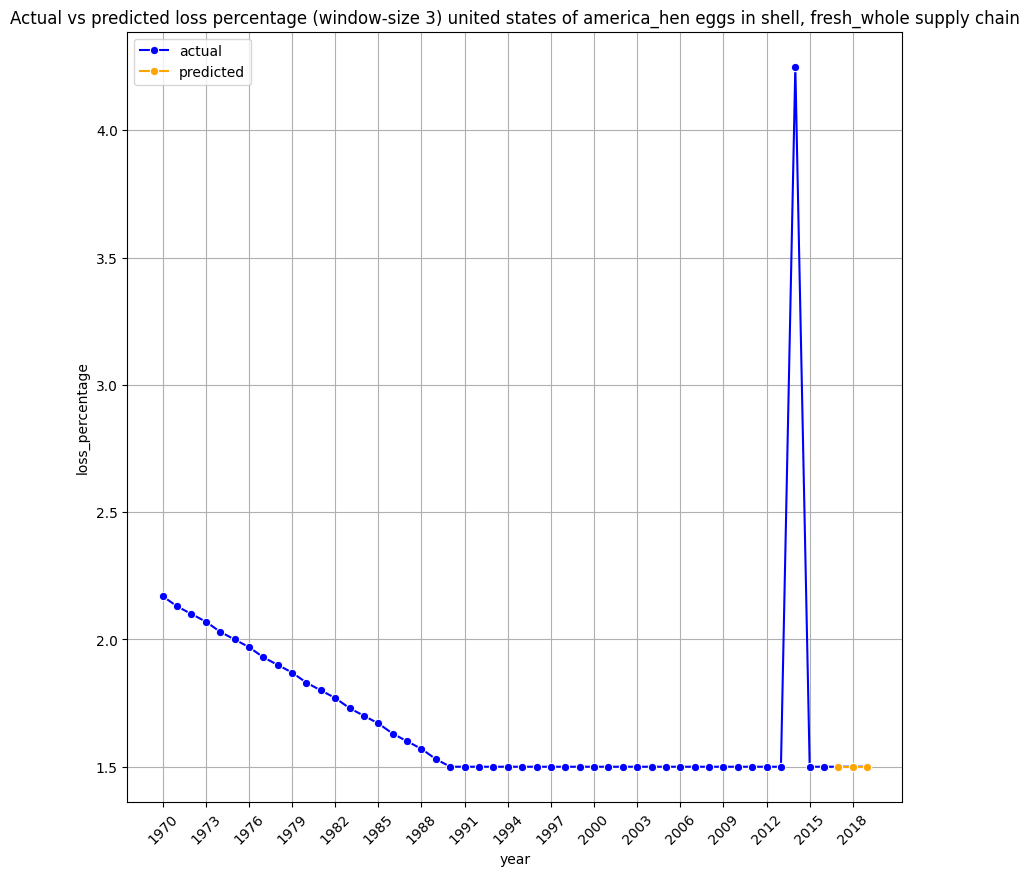

 18%|█▊        | 8/44 [04:16<20:08, 33.58s/it]

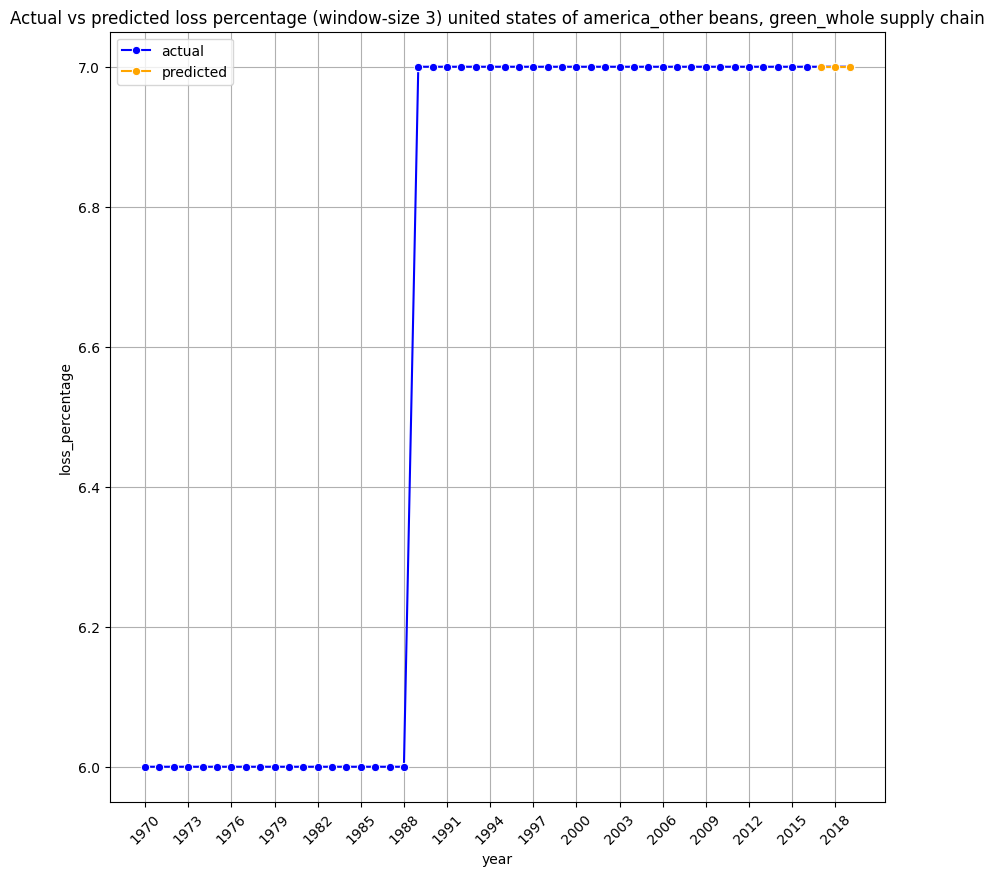

 20%|██        | 9/44 [04:53<20:08, 34.52s/it]

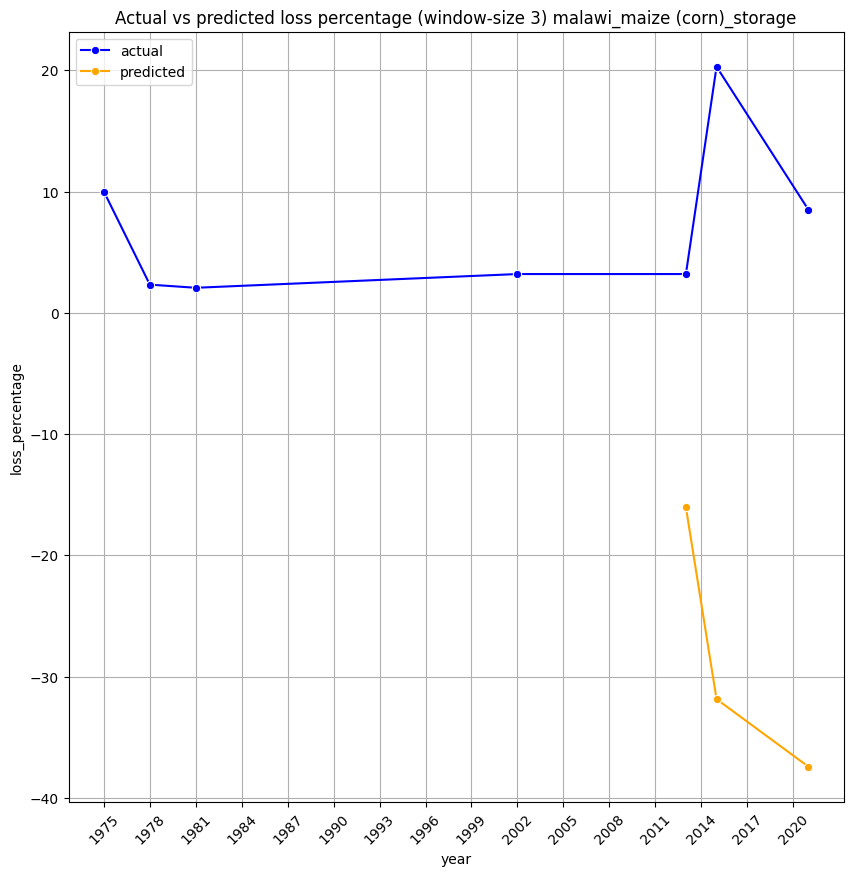

 23%|██▎       | 10/44 [05:28<19:35, 34.59s/it]

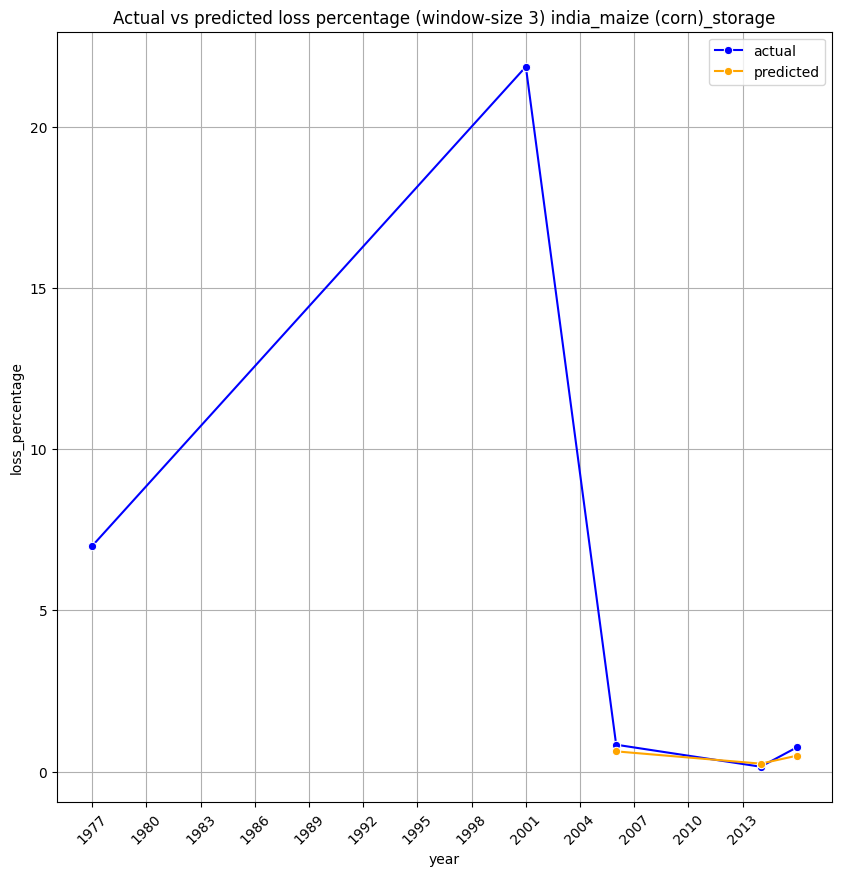

 25%|██▌       | 11/44 [06:02<19:02, 34.63s/it]

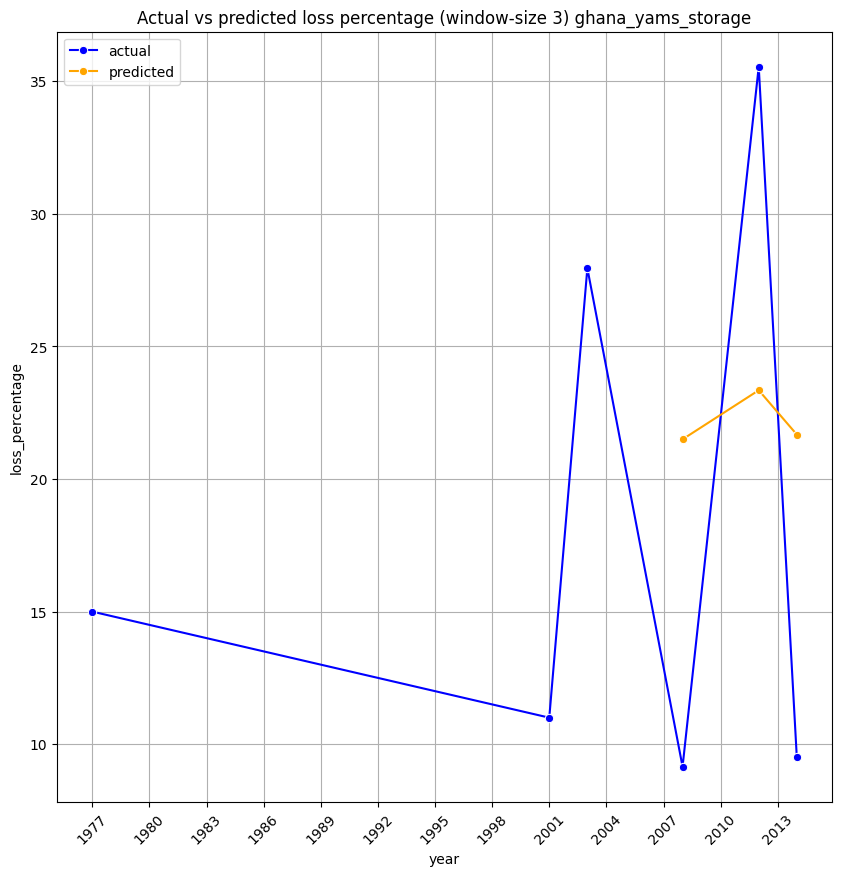

 27%|██▋       | 12/44 [06:34<17:55, 33.61s/it]

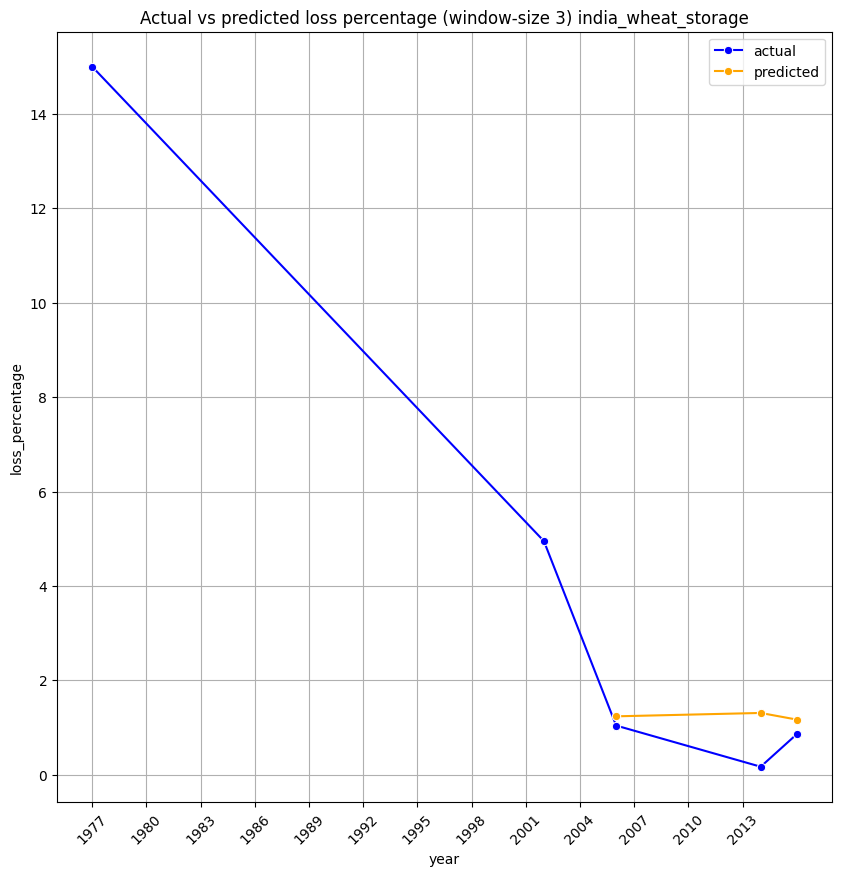

 30%|██▉       | 13/44 [07:06<17:06, 33.10s/it]

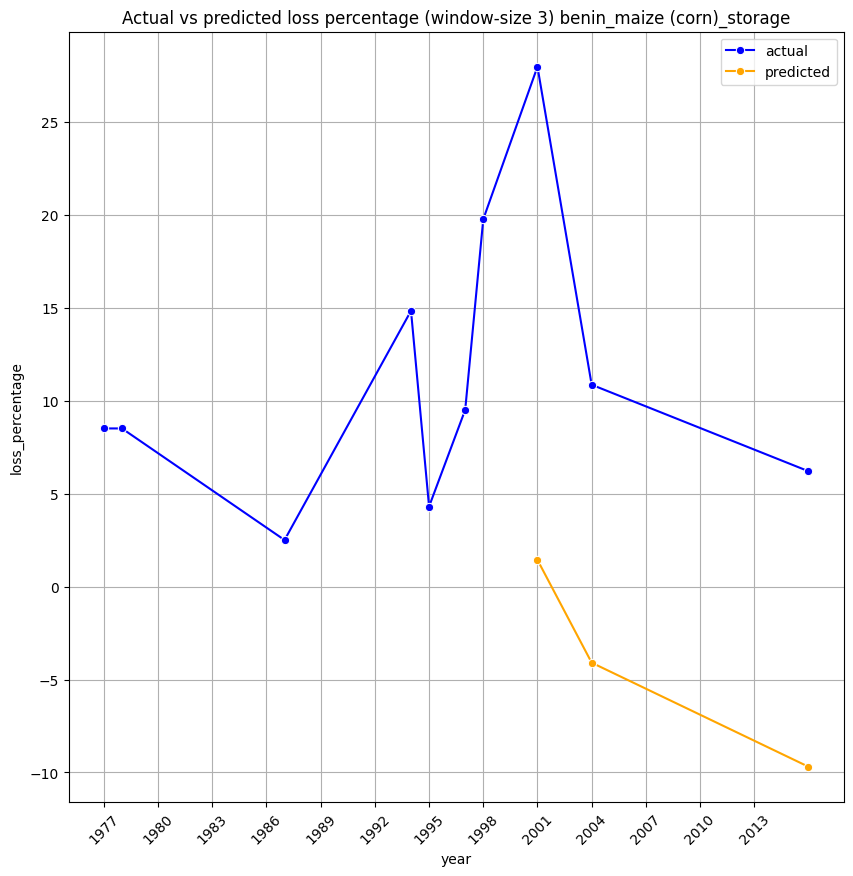

 32%|███▏      | 14/44 [07:37<16:19, 32.66s/it]

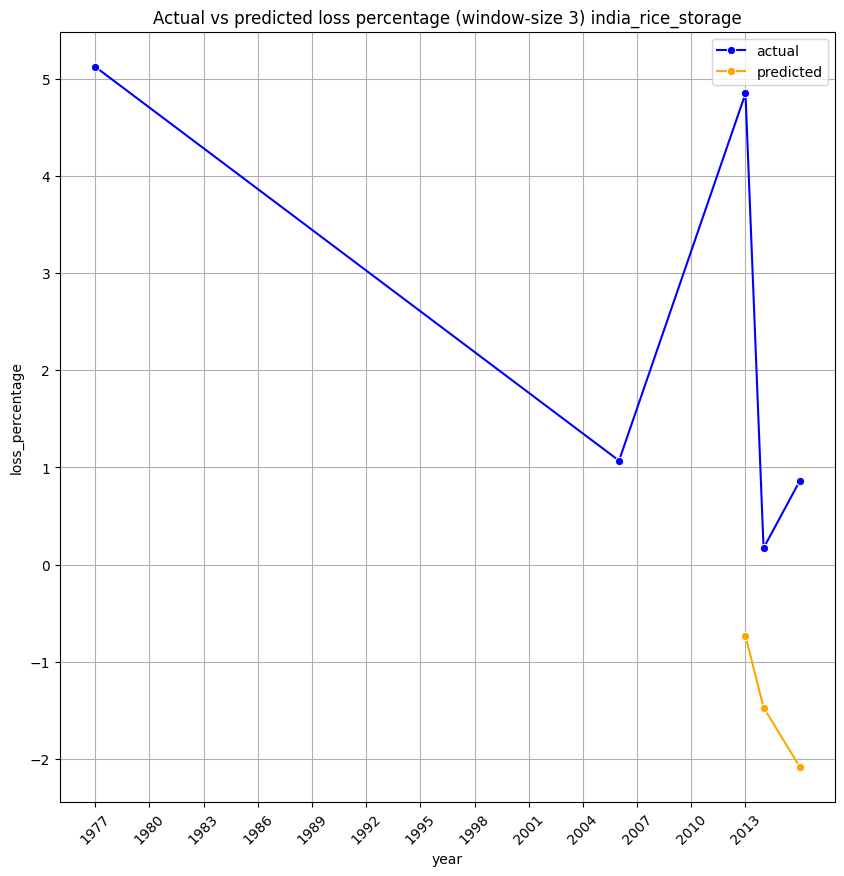

 34%|███▍      | 15/44 [08:09<15:39, 32.40s/it]

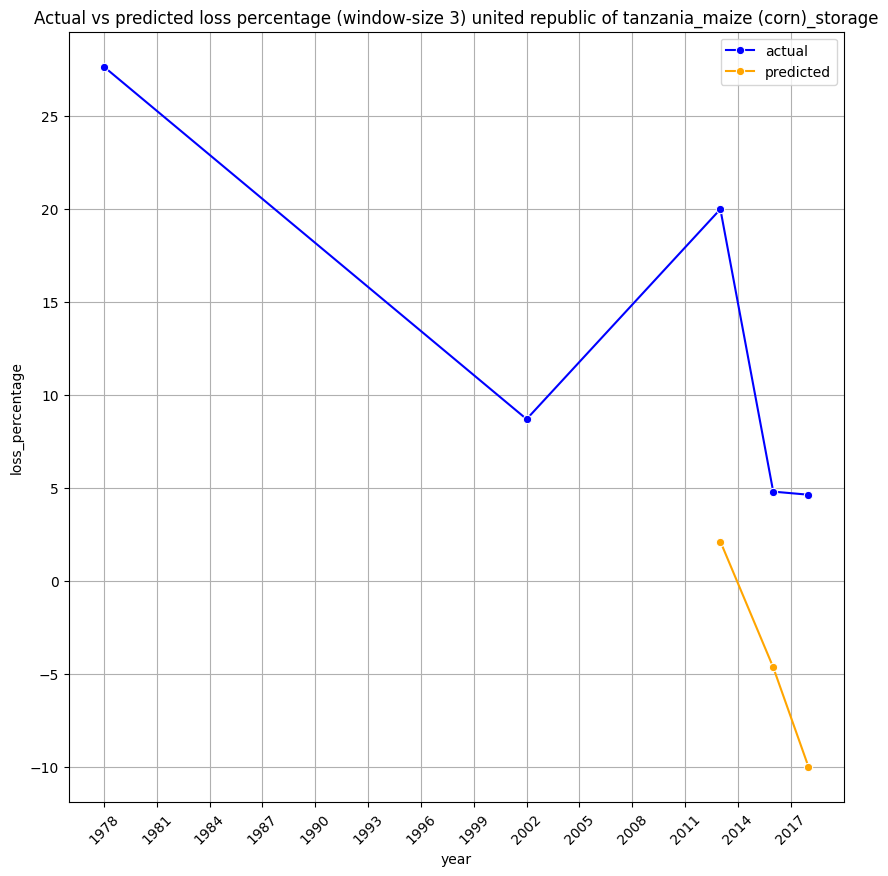

 36%|███▋      | 16/44 [08:41<14:58, 32.11s/it]

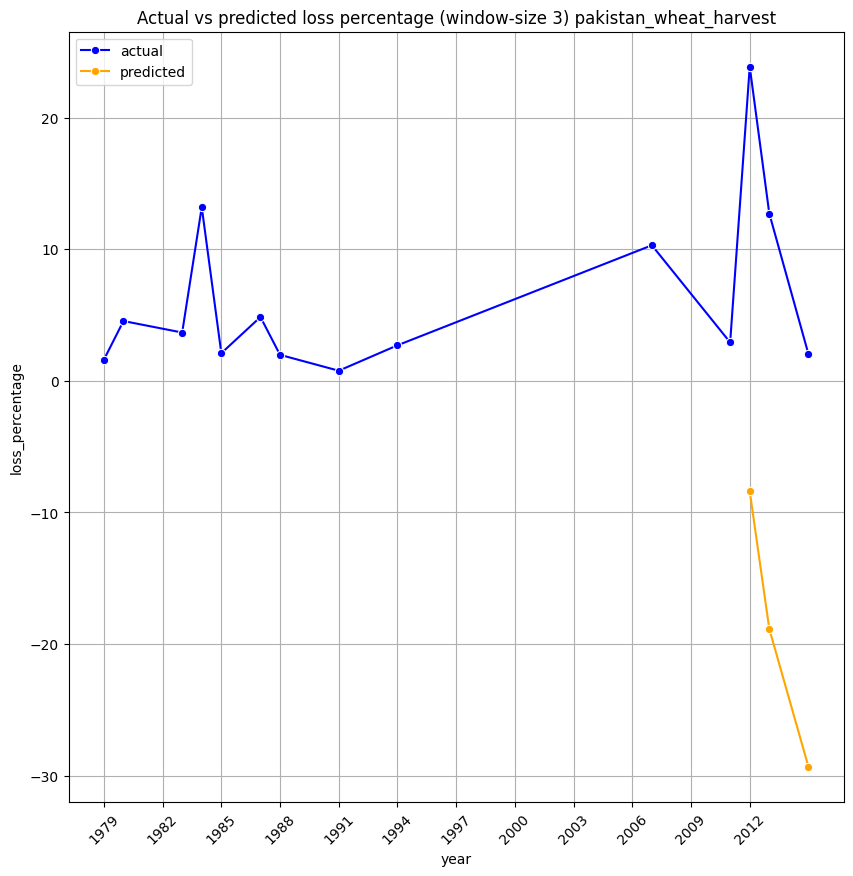

 39%|███▊      | 17/44 [09:11<14:15, 31.70s/it]

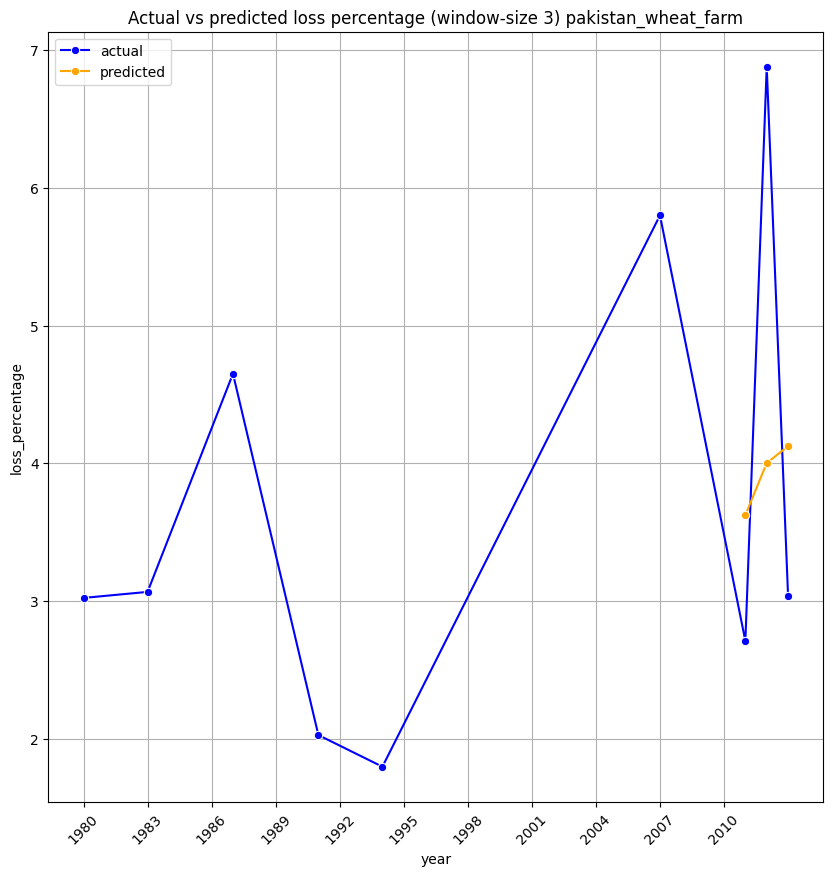

 41%|████      | 18/44 [09:42<13:33, 31.31s/it]

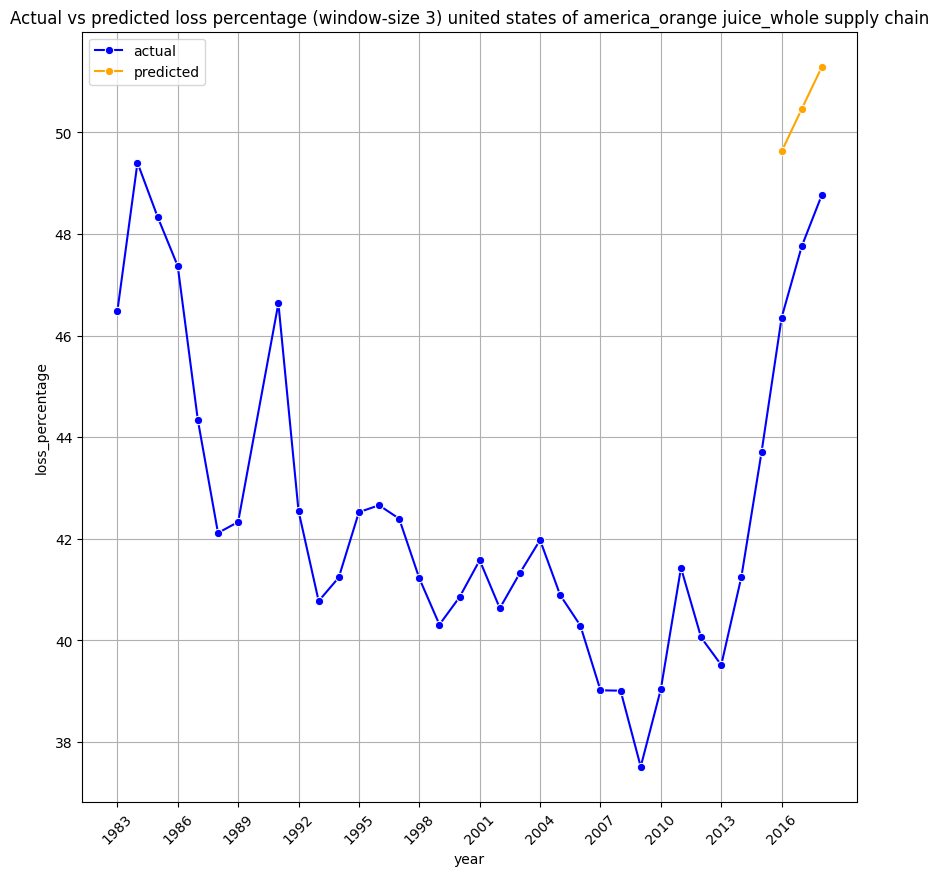

 43%|████▎     | 19/44 [10:12<12:51, 30.87s/it]

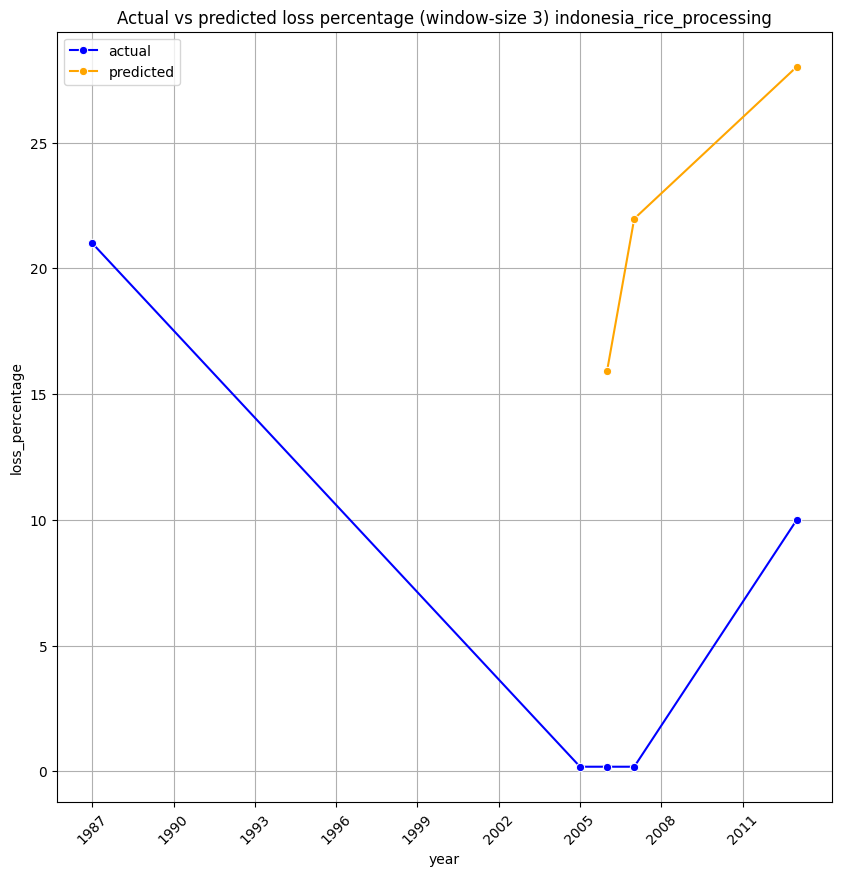

 45%|████▌     | 20/44 [10:41<12:08, 30.35s/it]

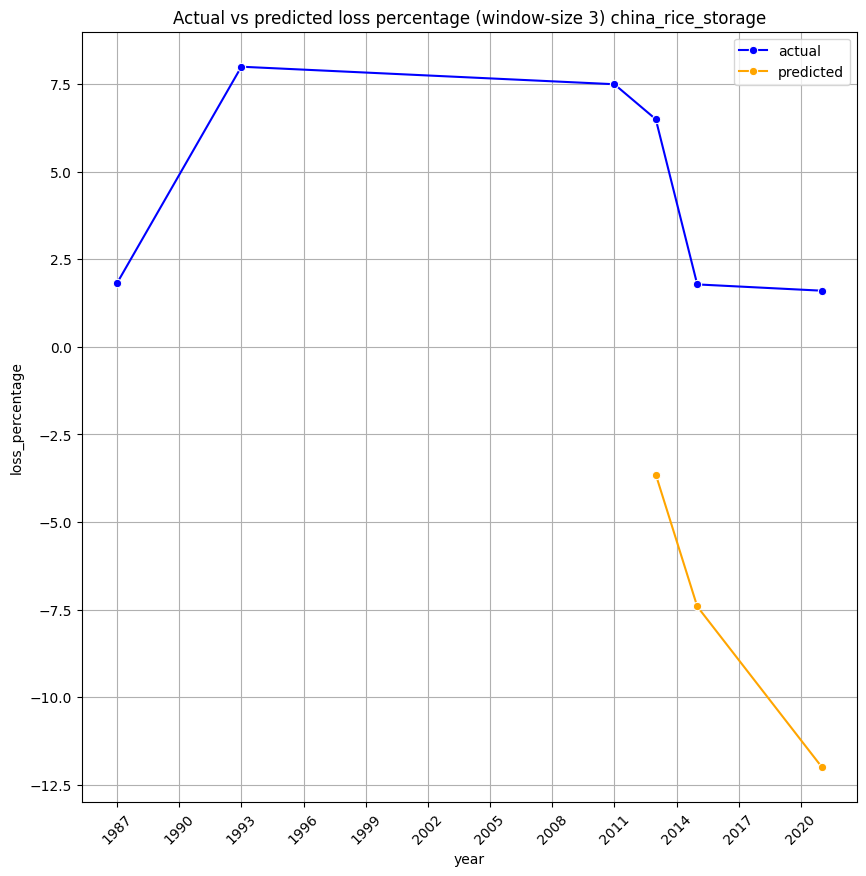

 48%|████▊     | 21/44 [11:06<11:00, 28.71s/it]

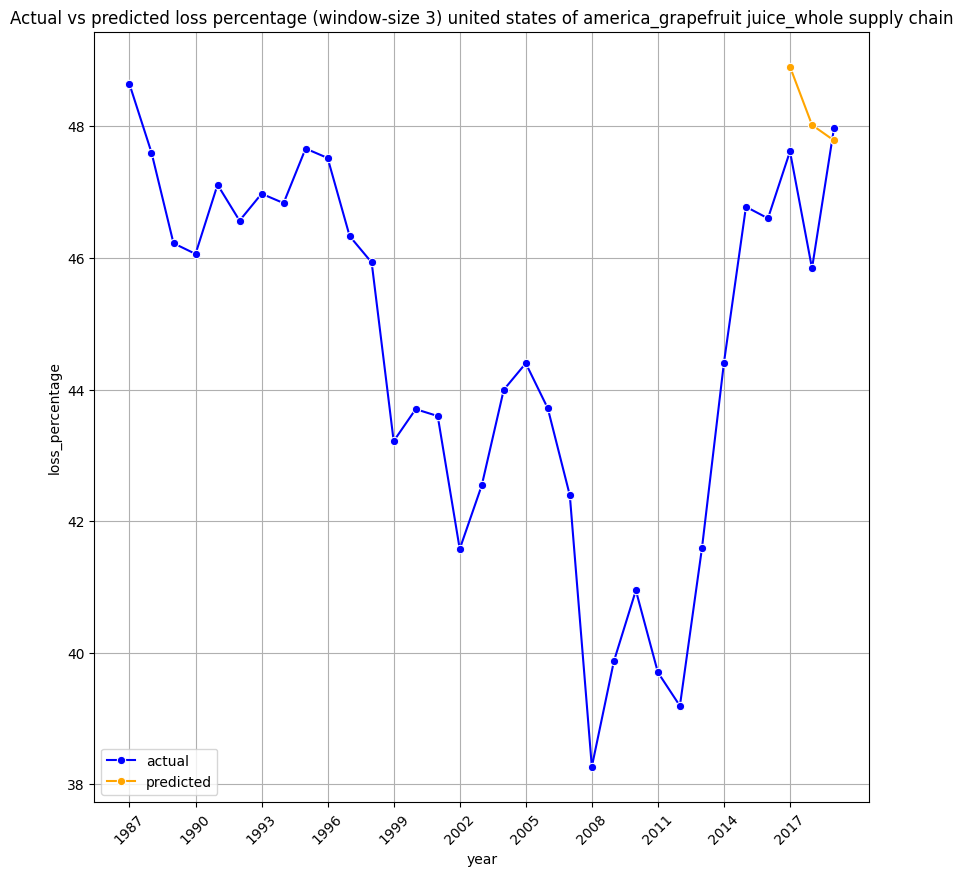

 50%|█████     | 22/44 [11:33<10:20, 28.21s/it]

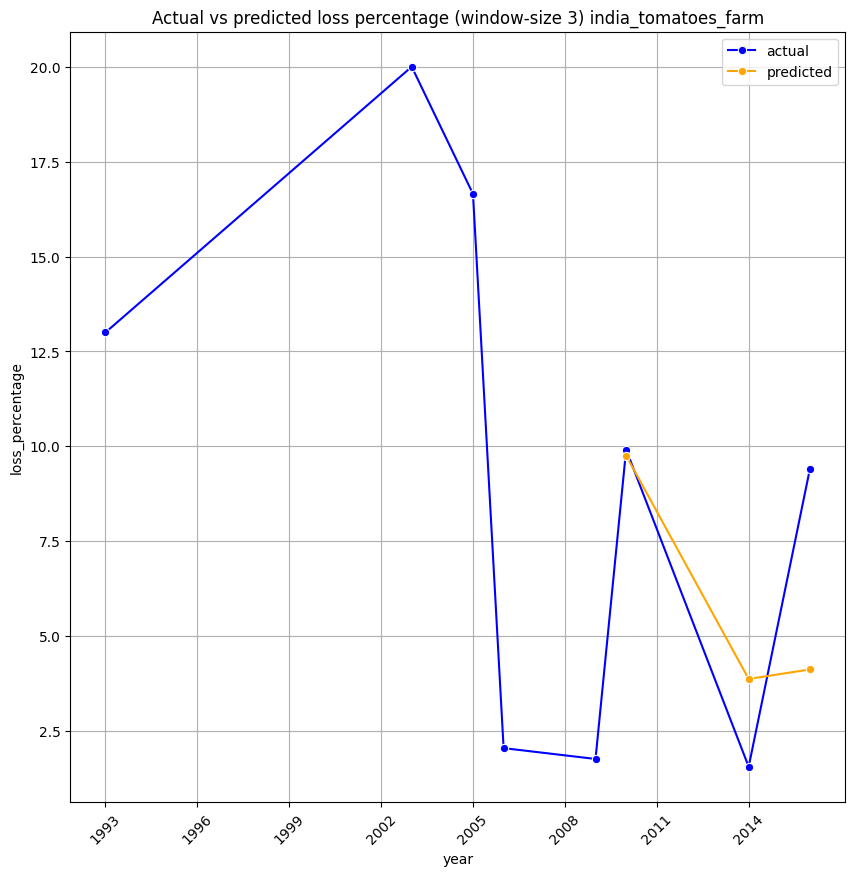

 52%|█████▏    | 23/44 [12:01<09:51, 28.15s/it]

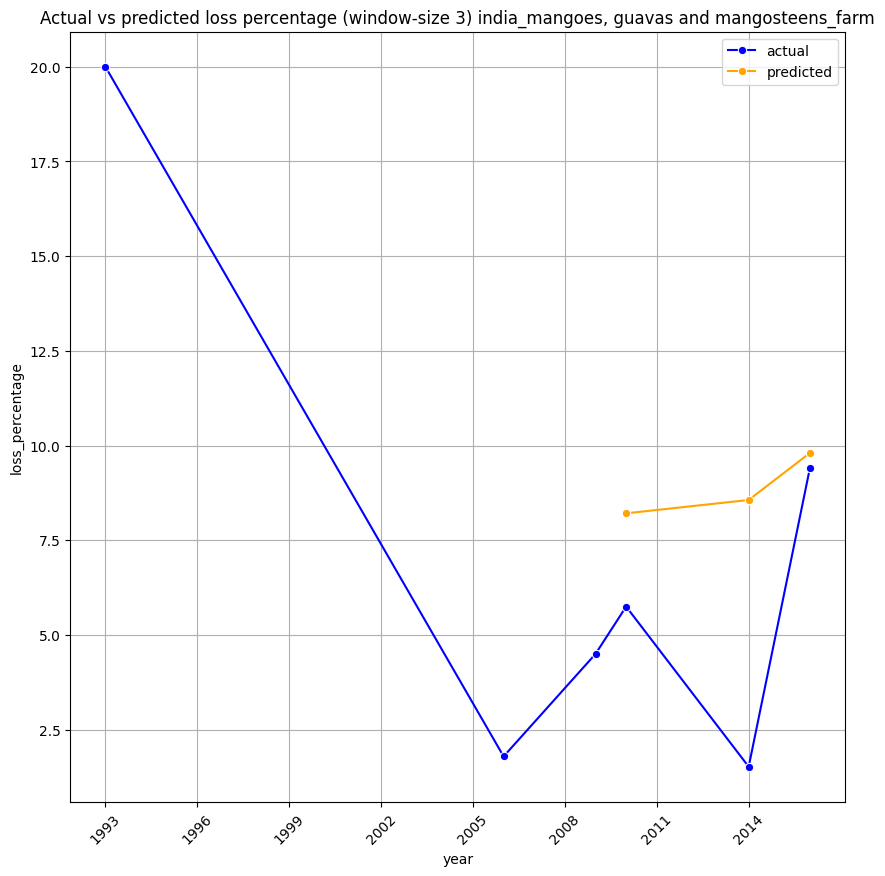

 55%|█████▍    | 24/44 [12:30<09:28, 28.41s/it]

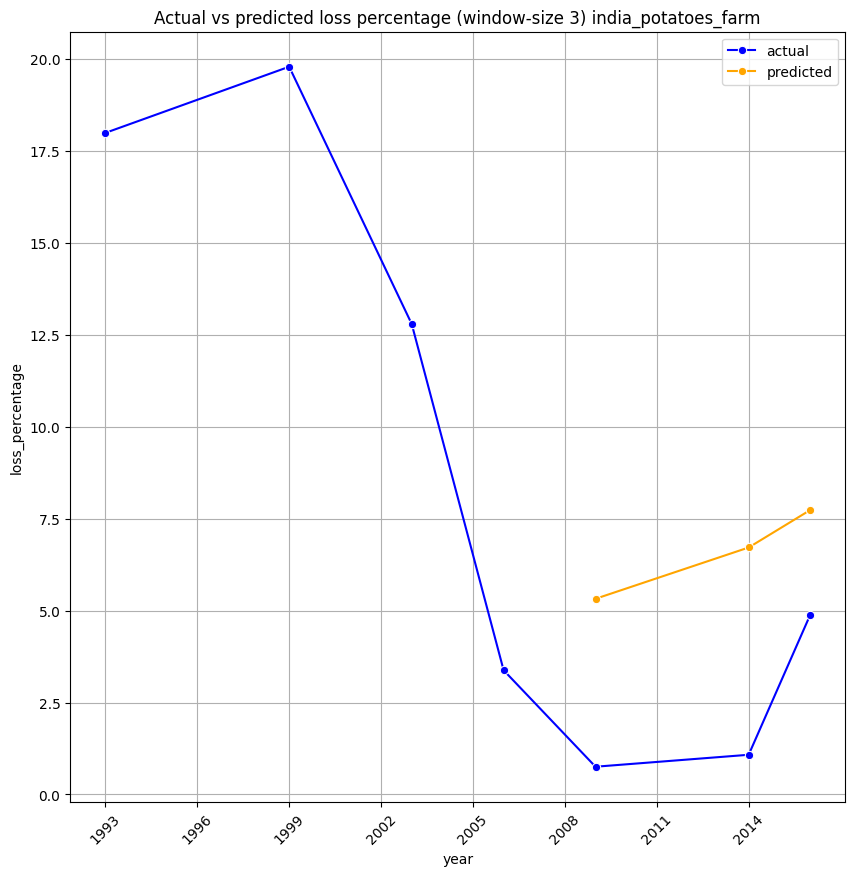

 57%|█████▋    | 25/44 [12:57<08:51, 27.97s/it]

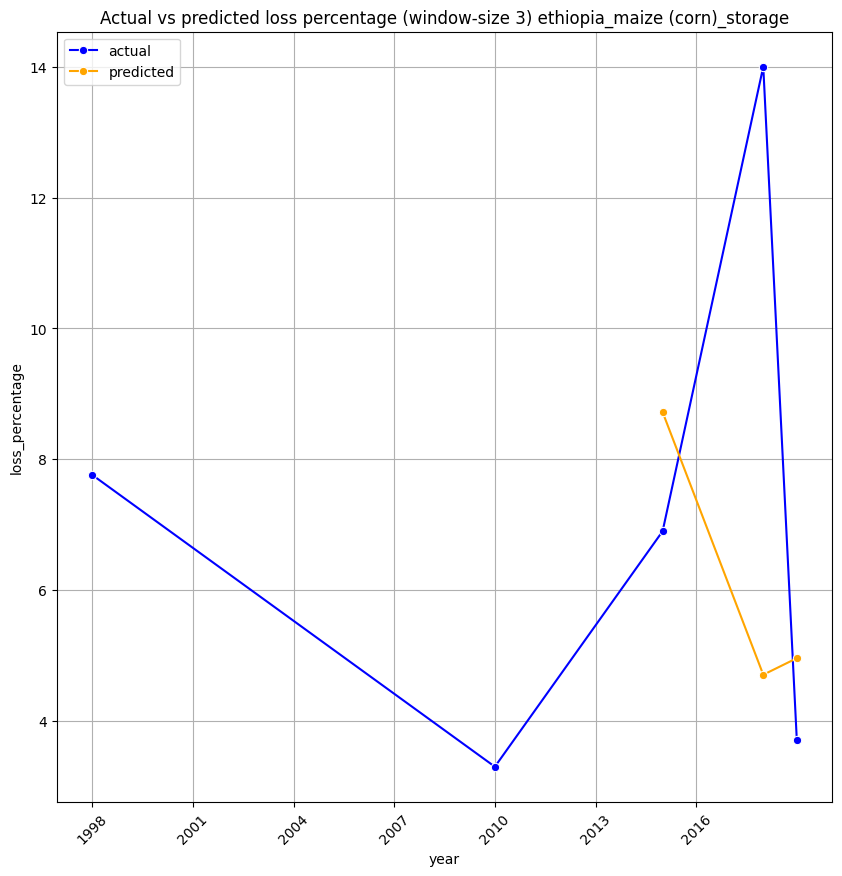

 59%|█████▉    | 26/44 [13:27<08:36, 28.70s/it]

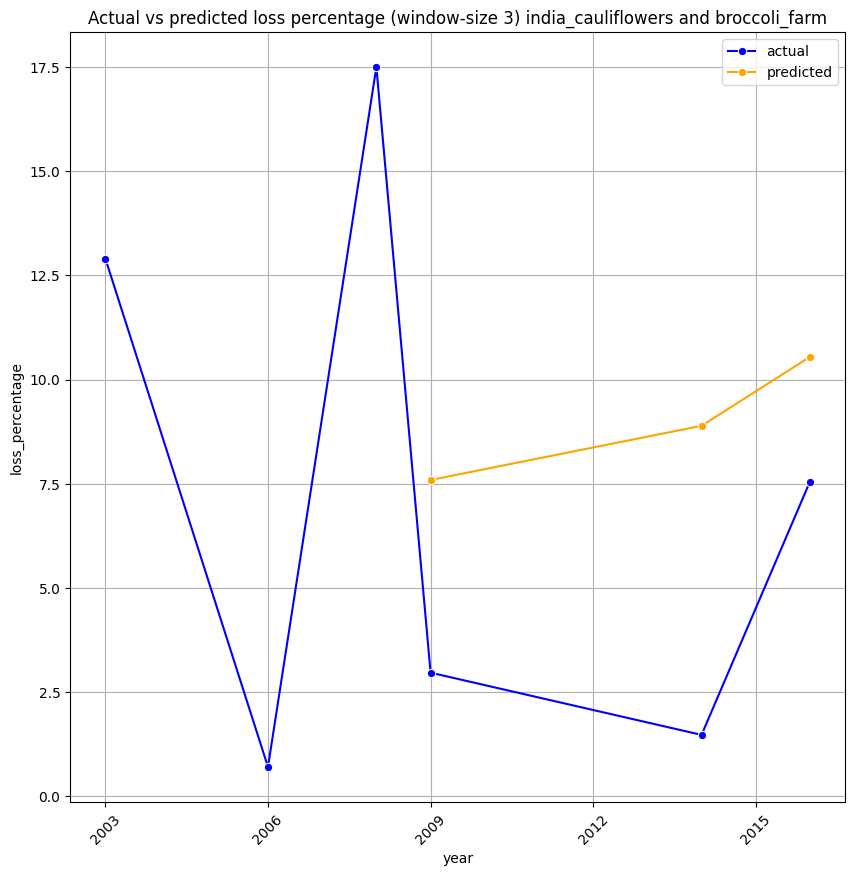

 61%|██████▏   | 27/44 [13:57<08:14, 29.11s/it]

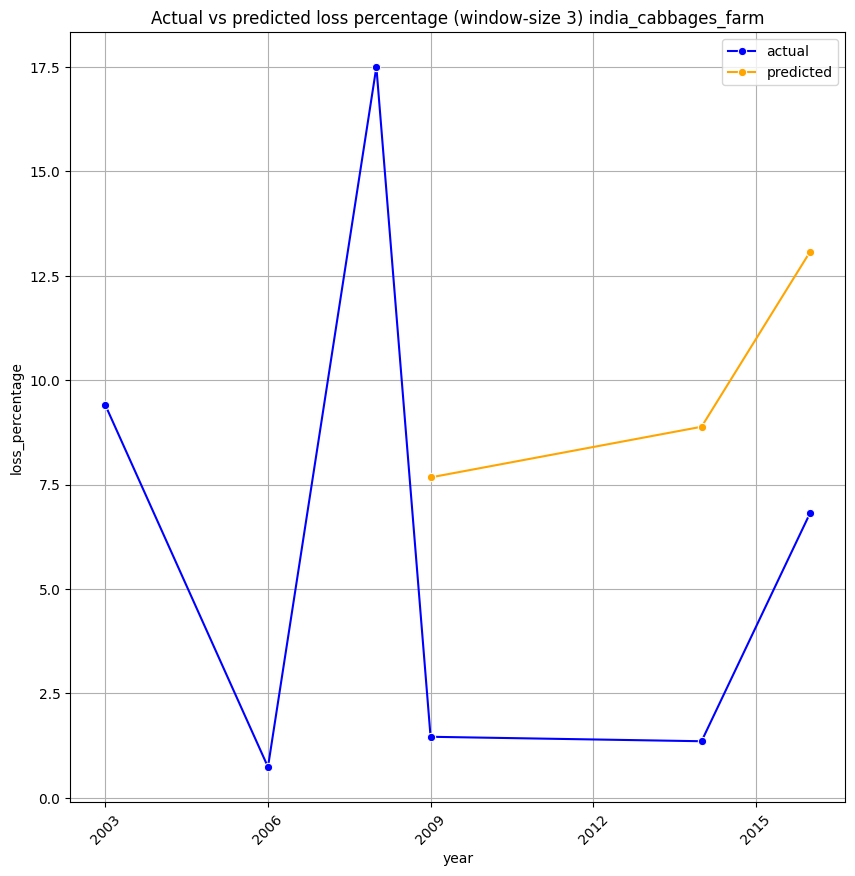

 64%|██████▎   | 28/44 [14:23<07:30, 28.16s/it]

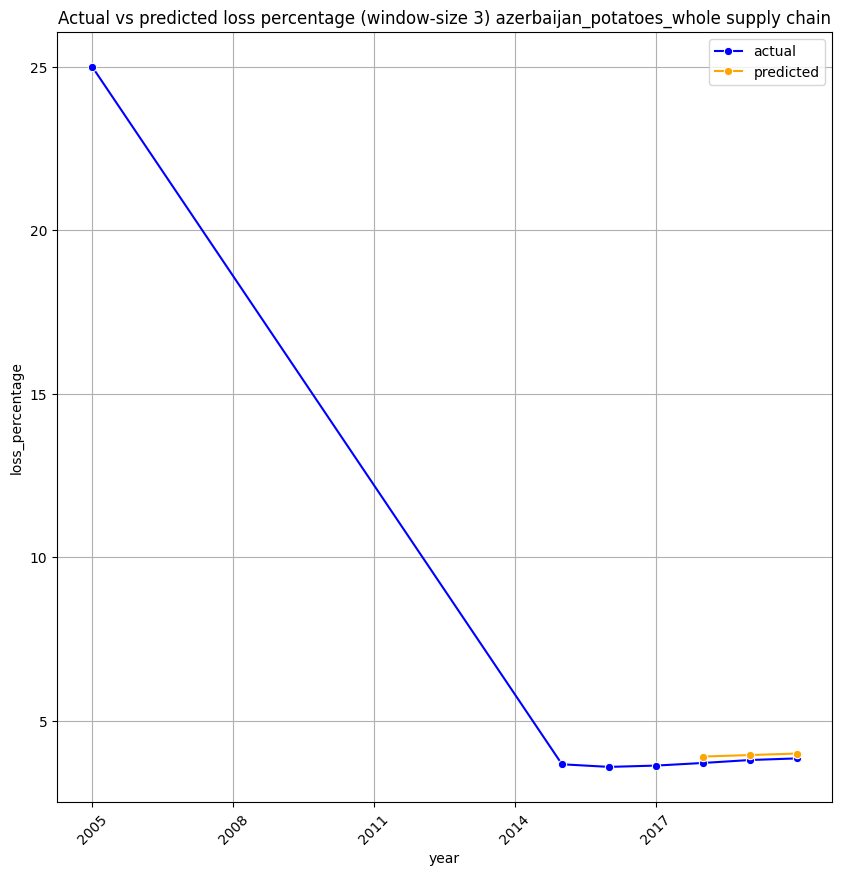

 66%|██████▌   | 29/44 [14:53<07:09, 28.62s/it]

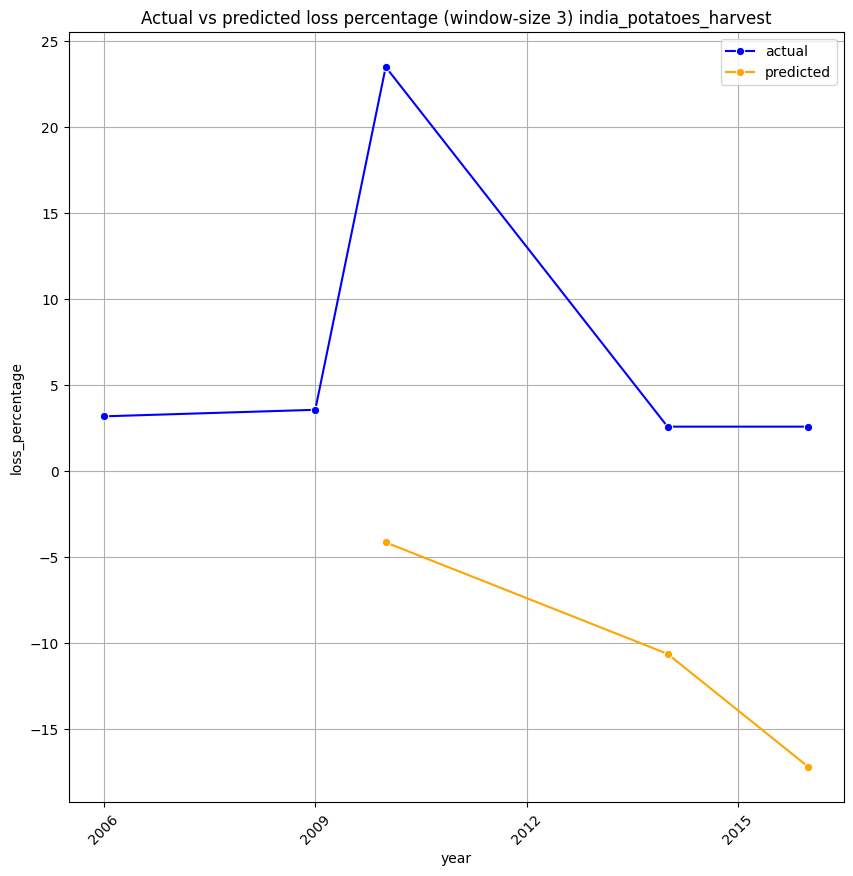

 68%|██████▊   | 30/44 [15:18<06:26, 27.64s/it]

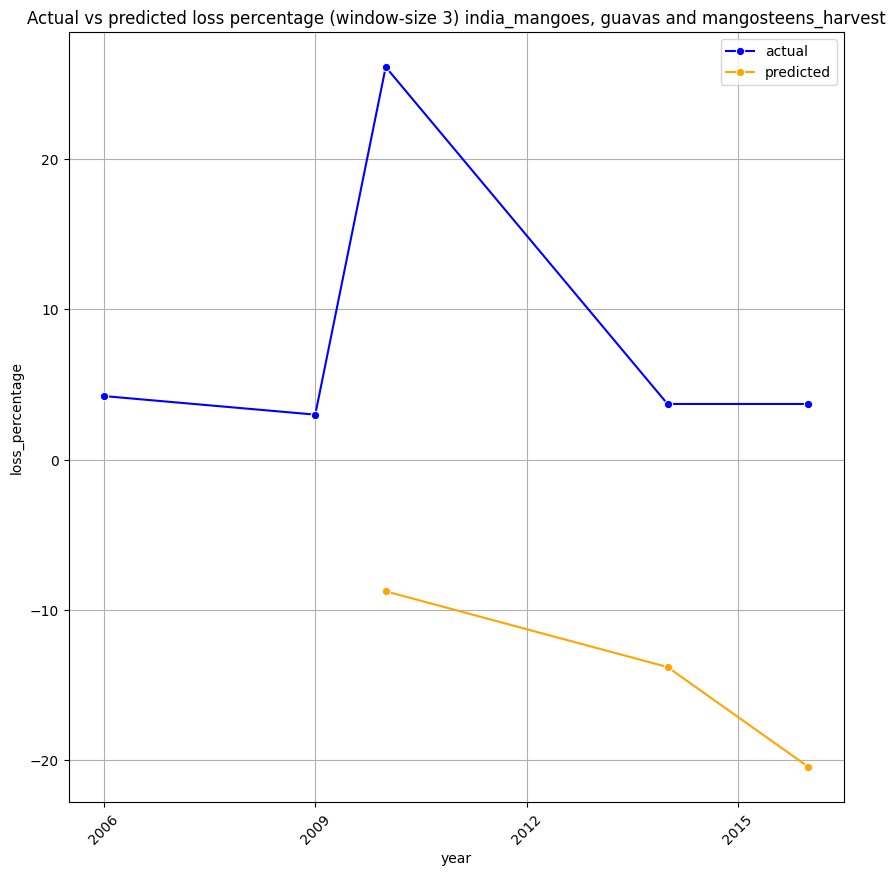

 70%|███████   | 31/44 [15:47<06:04, 28.03s/it]

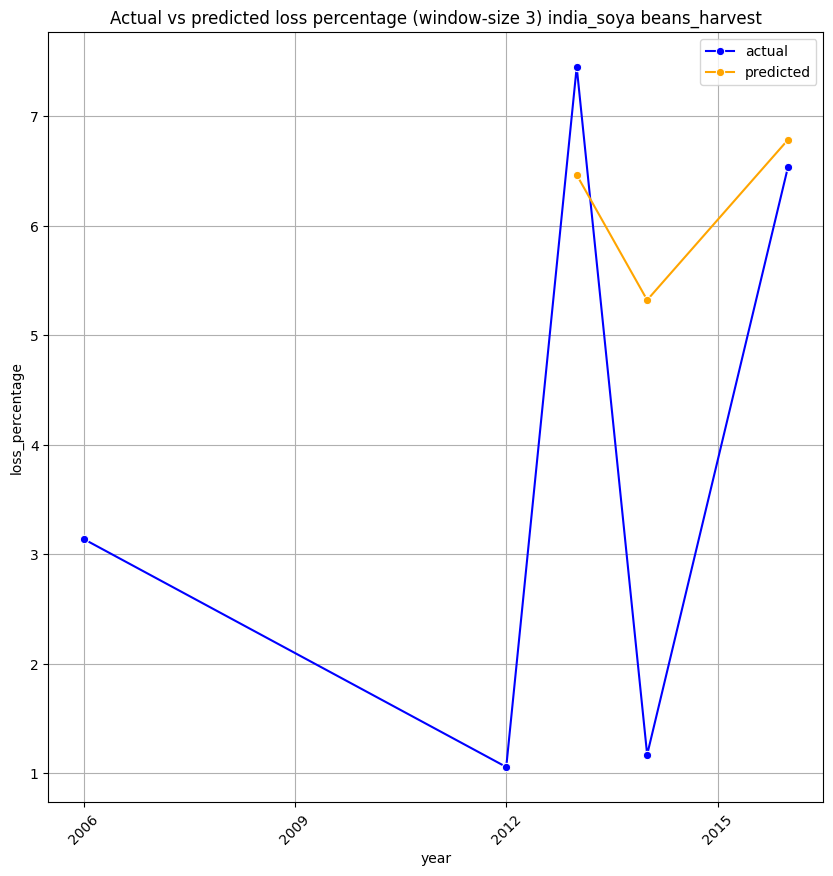

 73%|███████▎  | 32/44 [16:12<05:26, 27.18s/it]

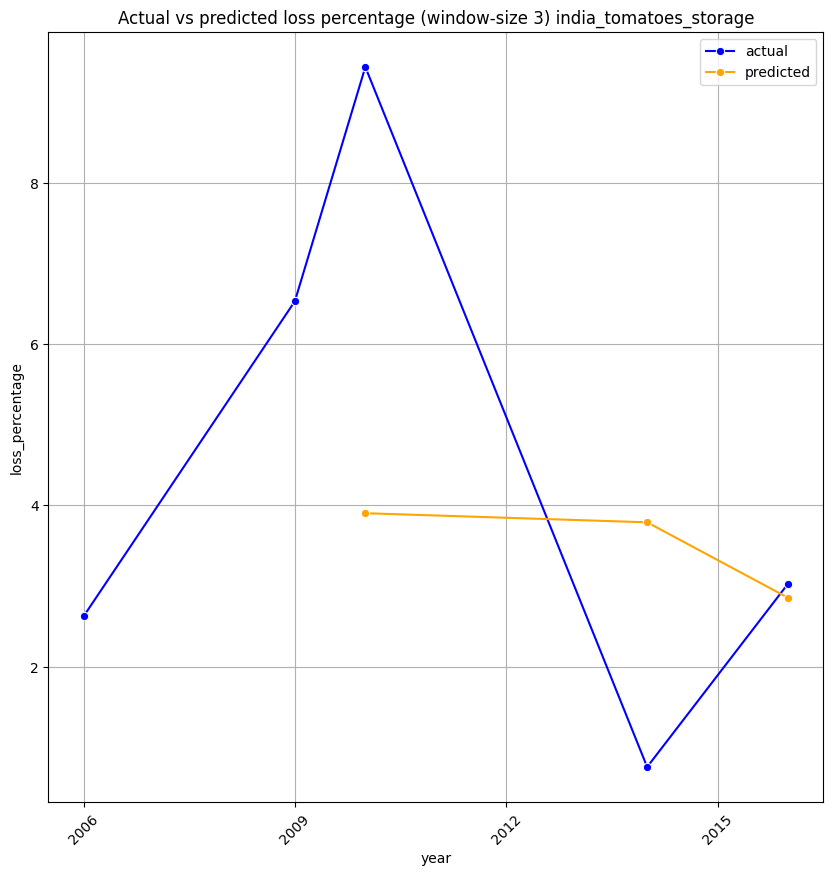

 75%|███████▌  | 33/44 [16:41<05:04, 27.72s/it]

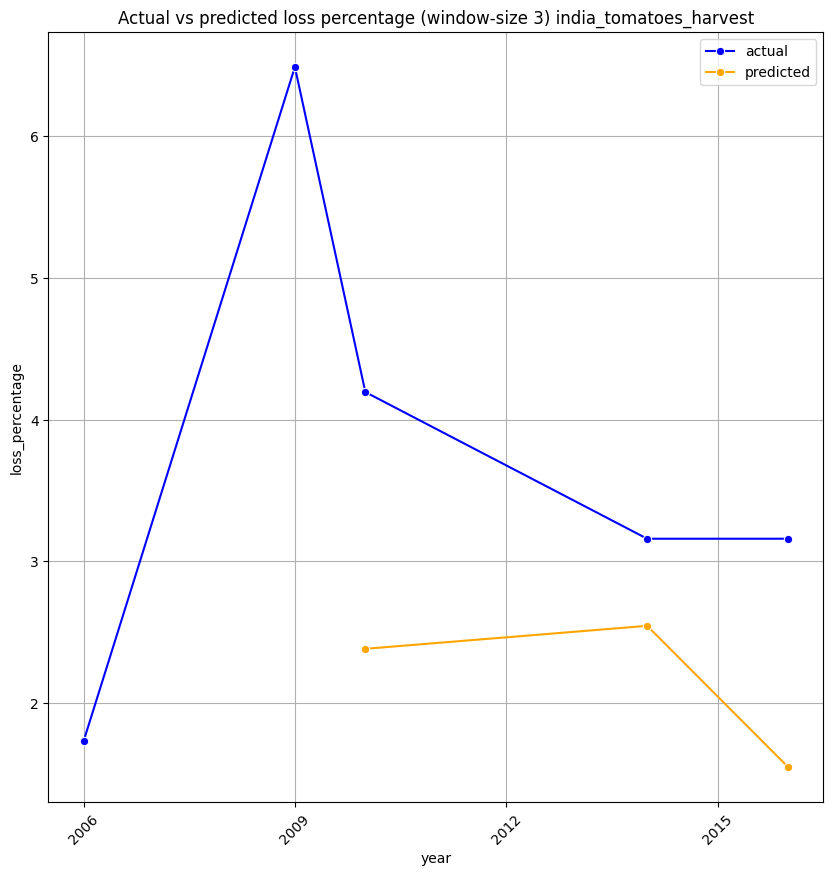

 77%|███████▋  | 34/44 [17:07<04:31, 27.17s/it]

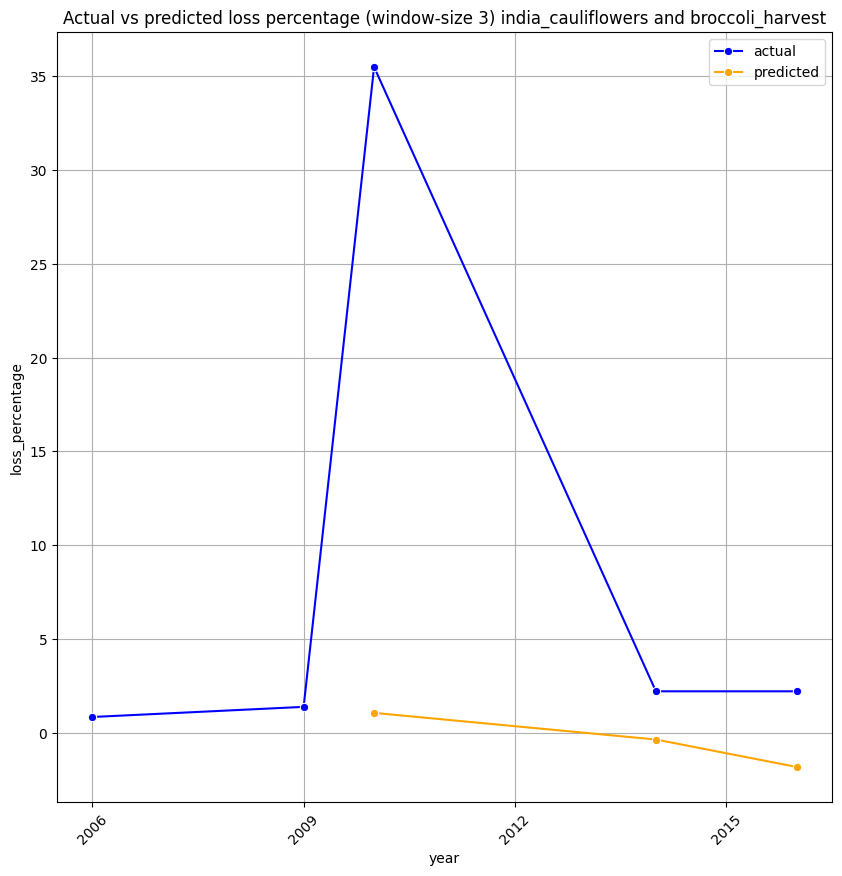

 80%|███████▉  | 35/44 [17:38<04:15, 28.42s/it]

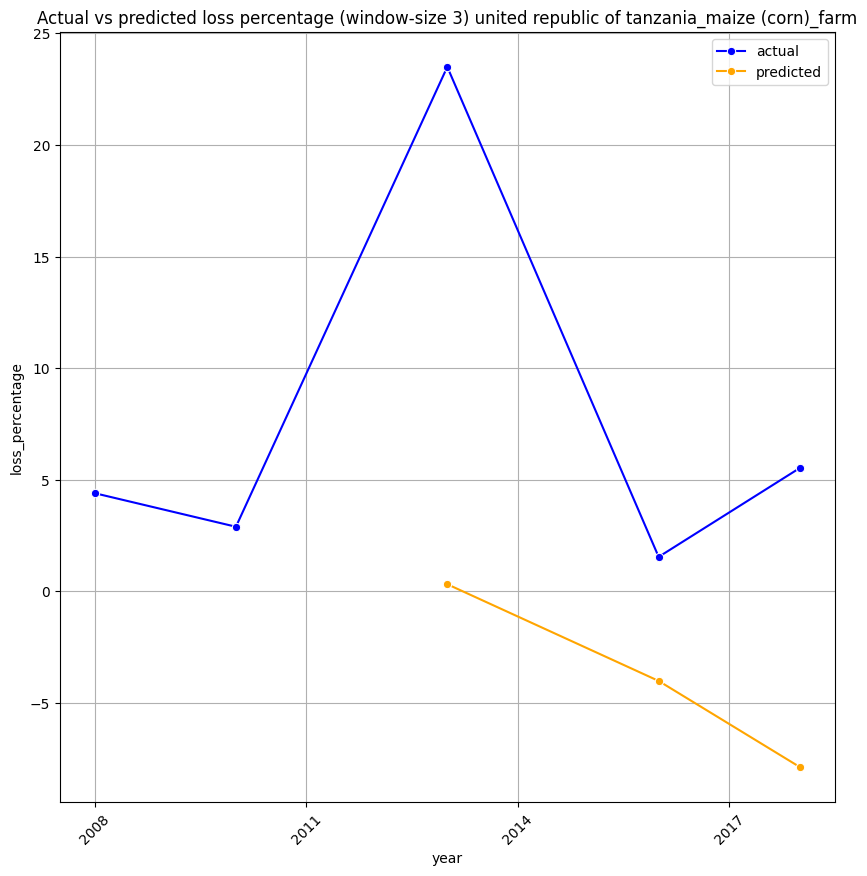

 82%|████████▏ | 36/44 [18:05<03:43, 27.93s/it]

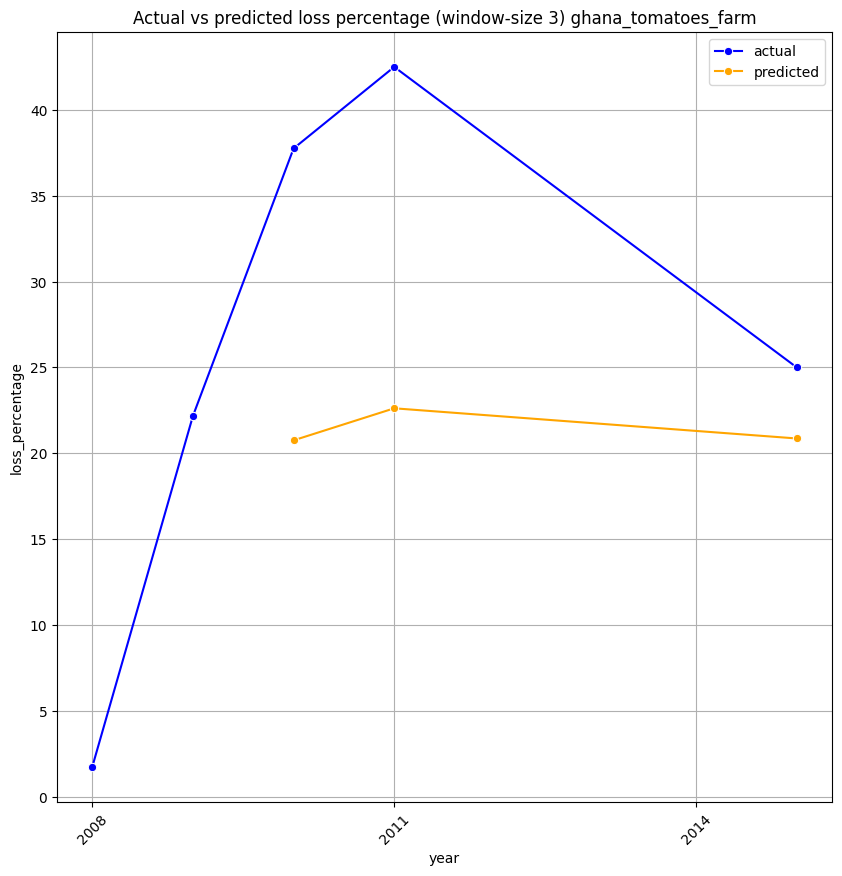

 84%|████████▍ | 37/44 [18:37<03:24, 29.24s/it]

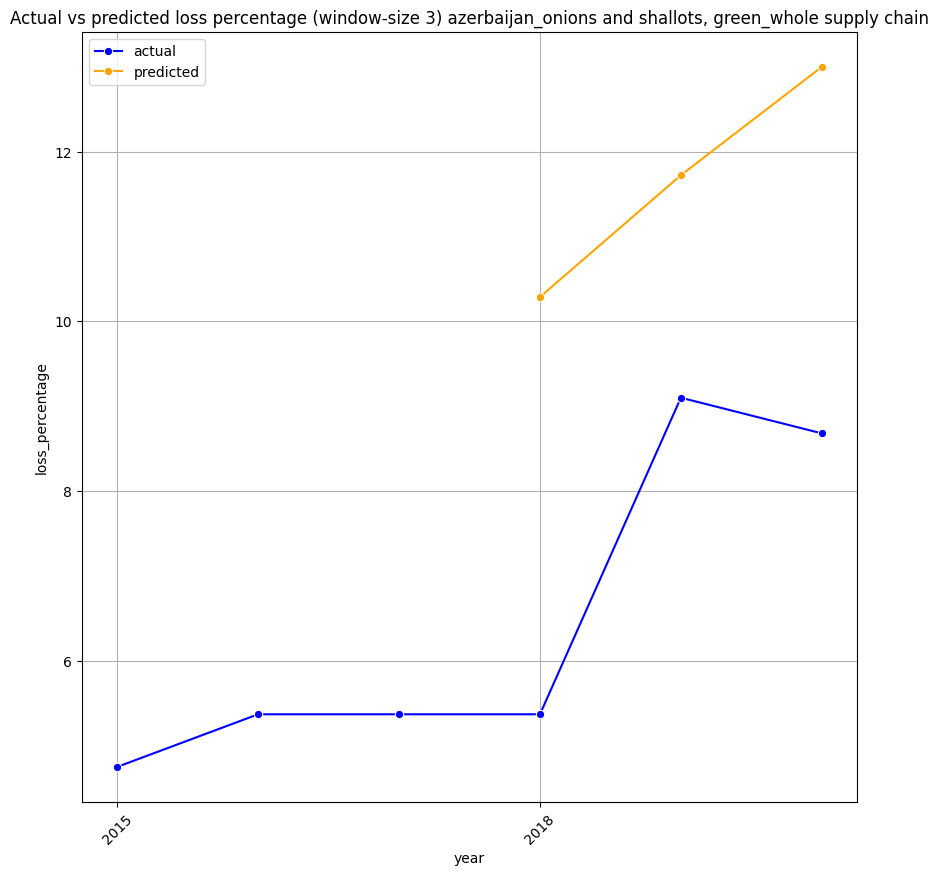

 86%|████████▋ | 38/44 [19:05<02:52, 28.67s/it]

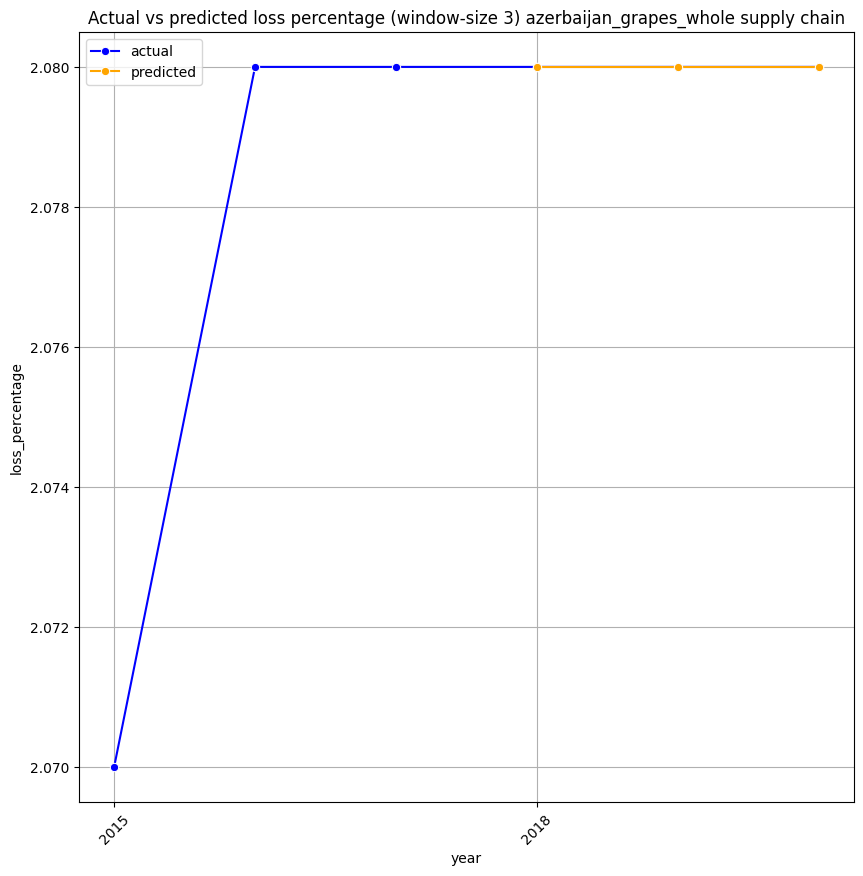

 89%|████████▊ | 39/44 [19:38<02:29, 29.92s/it]

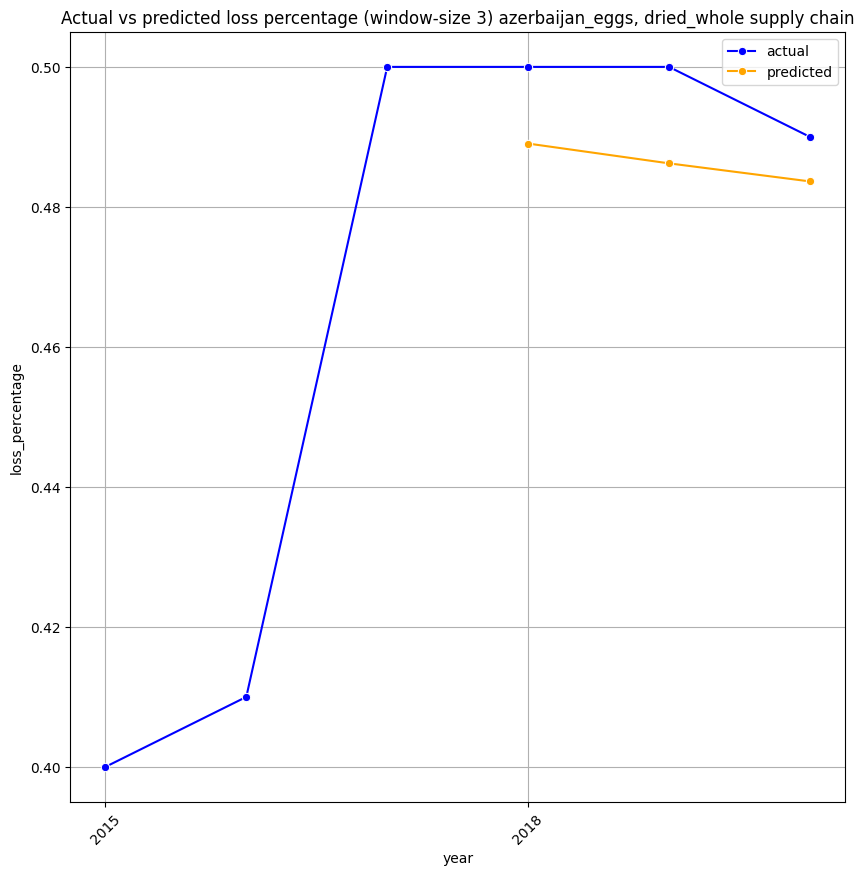

 91%|█████████ | 40/44 [20:04<01:56, 29.00s/it]

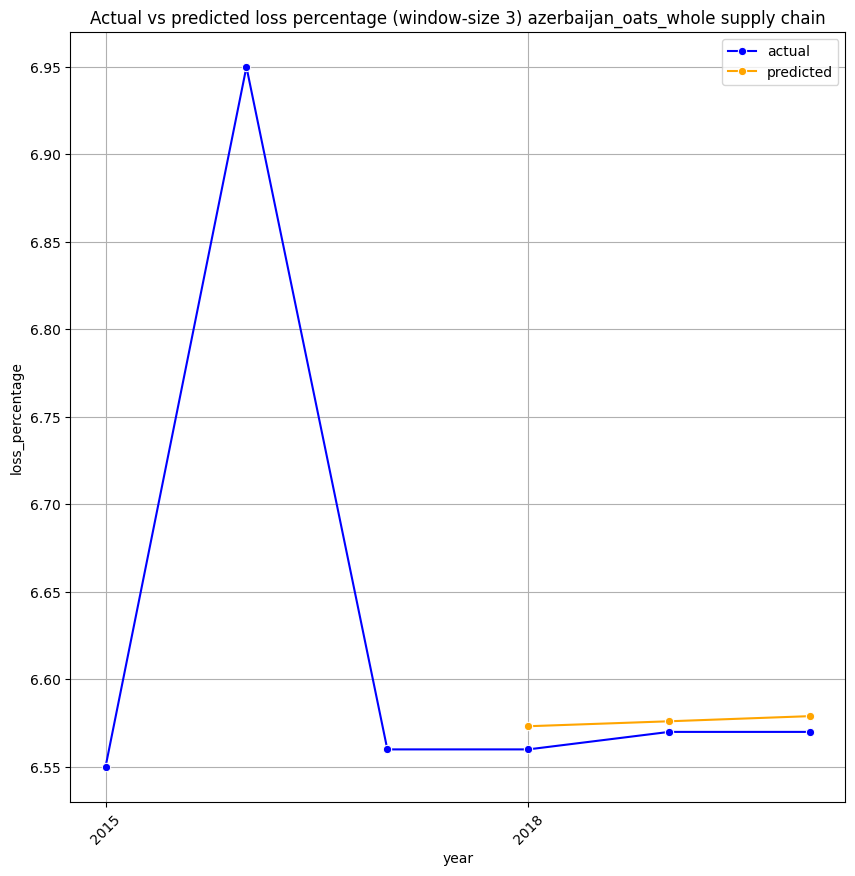

 93%|█████████▎| 41/44 [20:37<01:29, 29.94s/it]

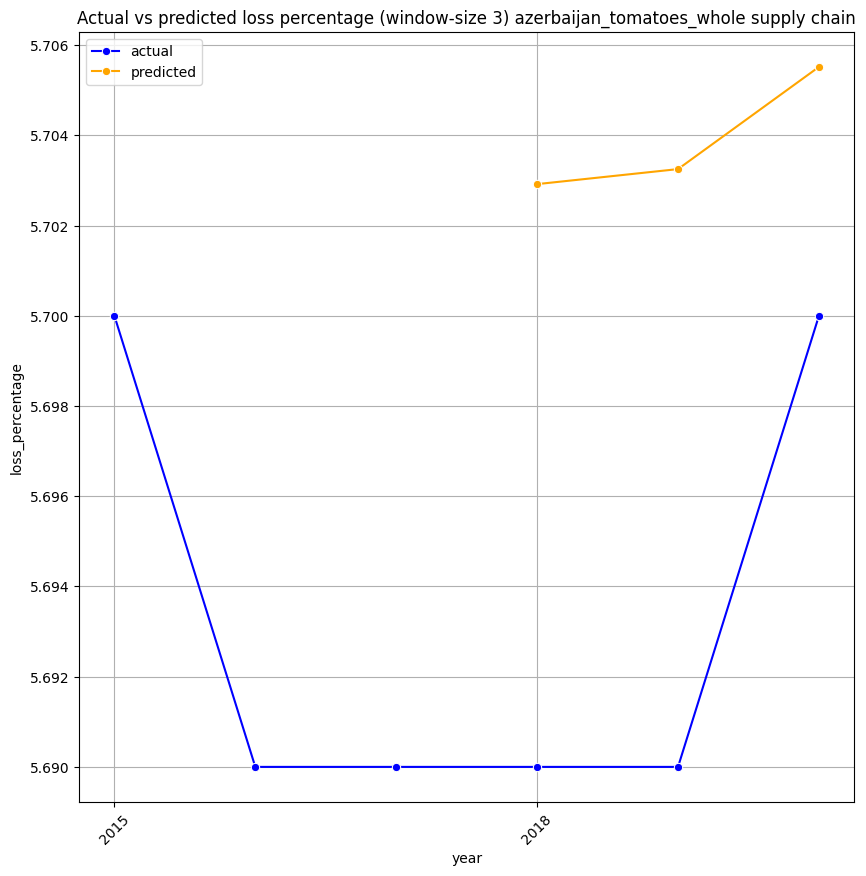

 95%|█████████▌| 42/44 [21:03<00:57, 28.89s/it]

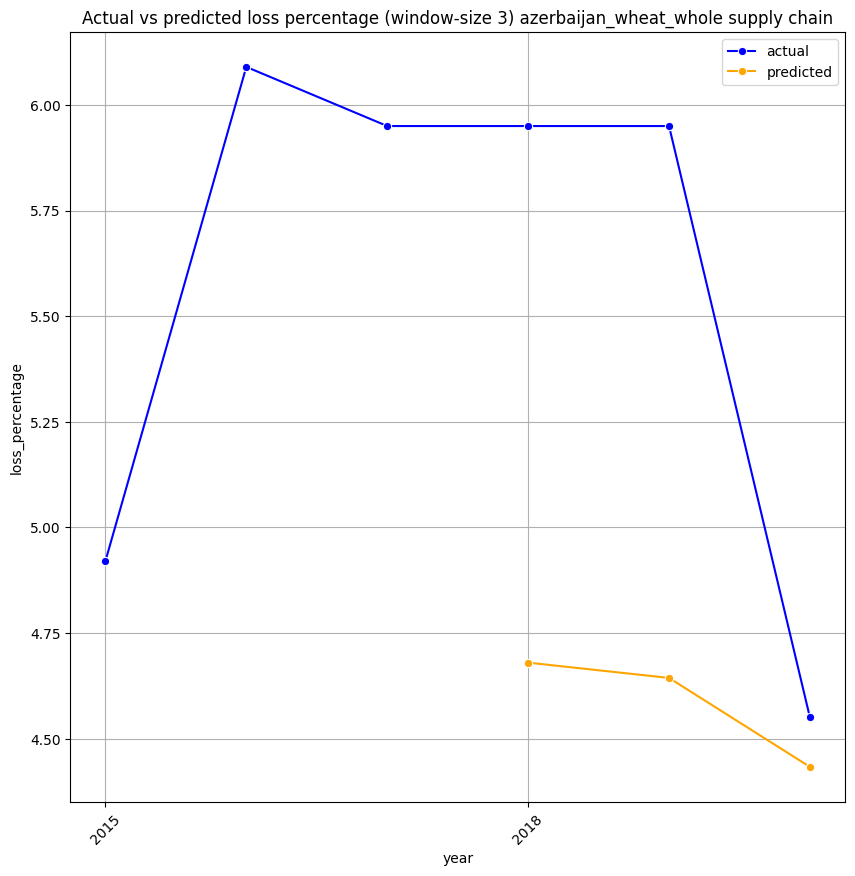

 98%|█████████▊| 43/44 [21:30<00:28, 28.36s/it]

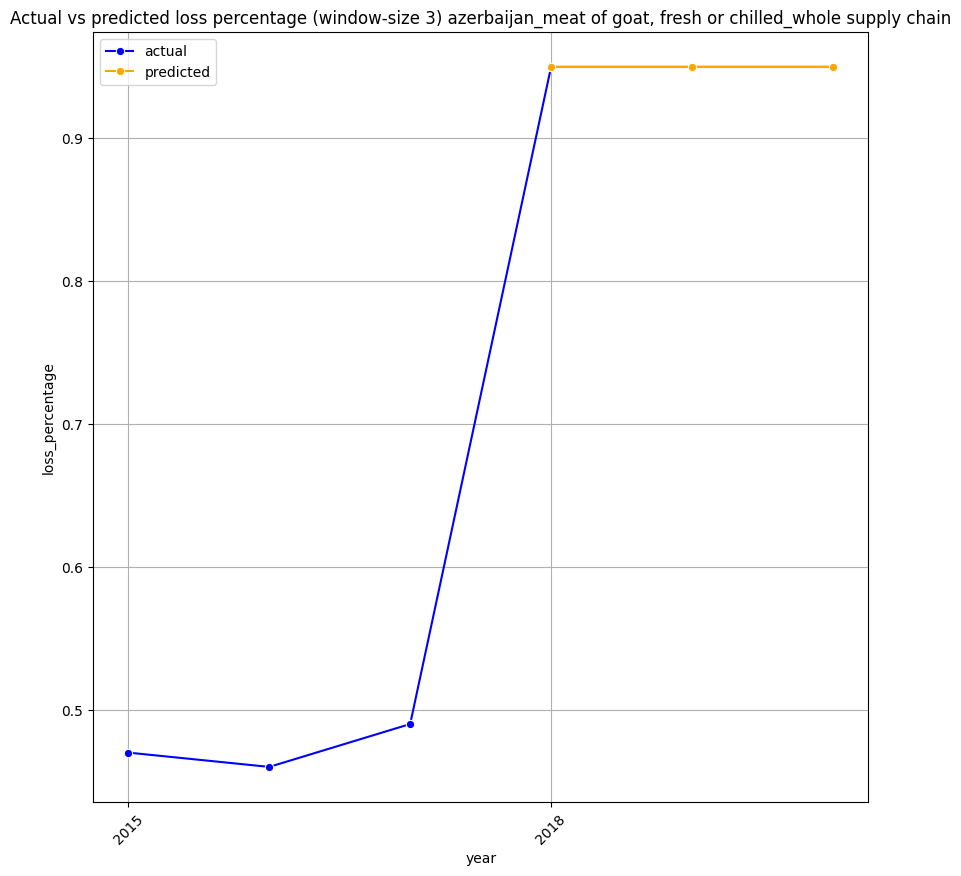

100%|██████████| 44/44 [22:02<00:00, 30.06s/it]


In [48]:
# Running the STS model on all keys


predictions = []
actuals = []

predictions_10 = []
actuals_10 = []

for key in tqdm(modeling_data.main_key.unique()):
    key_data = modeling_data[modeling_data.main_key == key]

    # Using all but the final 3 timesteps to train
    sample_data = key_data.loss_percentage[-3:]
    sample_model = build_model(sample_data)

    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=sample_model)

    num_variational_steps = 100

    # Build and optimize the variational loss function
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
      target_log_prob_fn=sample_model.joint_distribution(
          observed_time_series=sample_data).log_prob,
      surrogate_posterior=variational_posteriors,
      optimizer=tf.optimizers.Adam(learning_rate=0.01),
      num_steps=num_variational_steps,
      jit_compile=True)

    # Draw samples from the variational posterior
    q_samples_loss_ = variational_posteriors.sample(50)

    # Obtain sample forecasting distribution to sample from

    sample_forecast_dist = tfp.sts.forecast(
    sample_model,
    observed_time_series=sample_data,
    parameter_samples=q_samples_loss_,
    num_steps_forecast=3)

    num_samples=10

    sample_forecast_mean, sample_forecast_scale, sample_forecast_samples = (
      sample_forecast_dist.mean().numpy()[..., 0],
      sample_forecast_dist.stddev().numpy()[..., 0],
      sample_forecast_dist.sample(num_samples).numpy()[..., 0])

    plt.figure(figsize = (10,10))
    plt.title(f"Actual vs predicted loss percentage (window-size 3) {key}")
    sns.lineplot(x = key_data.year,
             y = key_data.loss_percentage,
             marker = "o", color = "blue", label = "actual")
    sns.lineplot(x = key_data.year[-3:],
              y = sample_forecast_mean,
              marker = "o", color = "orange", label = "predicted")
    plt.xticks(range(min(key_data.year),max(key_data.year),3), rotation = 45)
    plt.grid()
    plt.show()

    if len(key_data) >= 10:
    predictions_10.append(sample_forecast_mean)
    actuals_10.append(key_data.loss_percentage[-3:])

    predictions.append(sample_forecast_mean)
    actuals.append(key_data.loss_percentage[-3:])





In [49]:
print("Inferred parameters:")
for param in sample_model.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_loss_[param.name], axis=0),
                              np.std(q_samples_loss_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 4.0164111486057586e-17 +- 8.137450986305175e-19
ARIMA/_ar_coefficients: [ 0.46432047 -0.00203259  0.02031641] +- [0.01800768 0.02454297 0.02124796]
ARIMA/_ma_coefficients: [-0.01194504  0.01183369  0.67134329] +- [0.02600759 0.02252146 0.02701977]
ARIMA/_level_scale: 1.6597134263436417 +- 0.020892990345860542
LocalLinearTrend/_level_scale: 9.220403464332287e-17 +- 1.9638122650604475e-18
LocalLinearTrend/_slope_scale: 1.4535463177541358e-17 +- 3.617562414162711e-19


In [50]:
predictions_10 = sum([], predictions_10)
actuals_10 = sum([], actuals_10)

predictions = sum([], predictions)
actuals = sum([], actuals)

In [51]:
print(f'RMSE long series = {np.round(np.sqrt(mean_squared_error(predictions_10, actuals_10)),2)} | MAPE = {np.round(100*mean_absolute_percentage_error(predictions_10, actuals_10),2)}% | R-squared = {np.round(r2_score(predictions_10, actuals_10),2)}')
print(f'RMSE all series = {np.round(np.sqrt(mean_squared_error(predictions, actuals)),2)} | MAPE = {np.round(100*mean_absolute_percentage_error(predictions, actuals),2)}% | R-squared = {np.round(r2_score(predictions, actuals),2)}')

RMSE long series = 11.33 | MAPE = 94.86% | R-squared = 0.66
RMSE all series = 12.52 | MAPE = 171.81% | R-squared = 0.17
